# PhysicsNeMo Tutorial

## 실습 예제 목록
### 기본 예제
##### 1. 1D Regression
##### 2. 2D Regression
##### 3. Boundary Value Problem : Poisson
### PINNs
##### 4. Burgers Equation
##### 5. 1D Wave Equation
##### 6. Lid Driven Cavity

# PhysicsNeMo 학습 코드 Flow

### PhysicsNeMo 학습 코드는 다음과 같은 Flow를 따릅니다.
#### 1. Define : Problem
#### 2. Load : Configuration
- 모델 학습 hyperparameter, optimizer등 setting을 저장

#### 3. Define : Geometry, Dataset, Model
- 데이터셋과 모델을 정의

#### 4. Define : Node -> Constraint -> Domain
- solver에 전달할 domain을 정의

#### 5. Create : Solver
- solver에 configuration 파일과 domain을 전달
- solver를 통해 학습

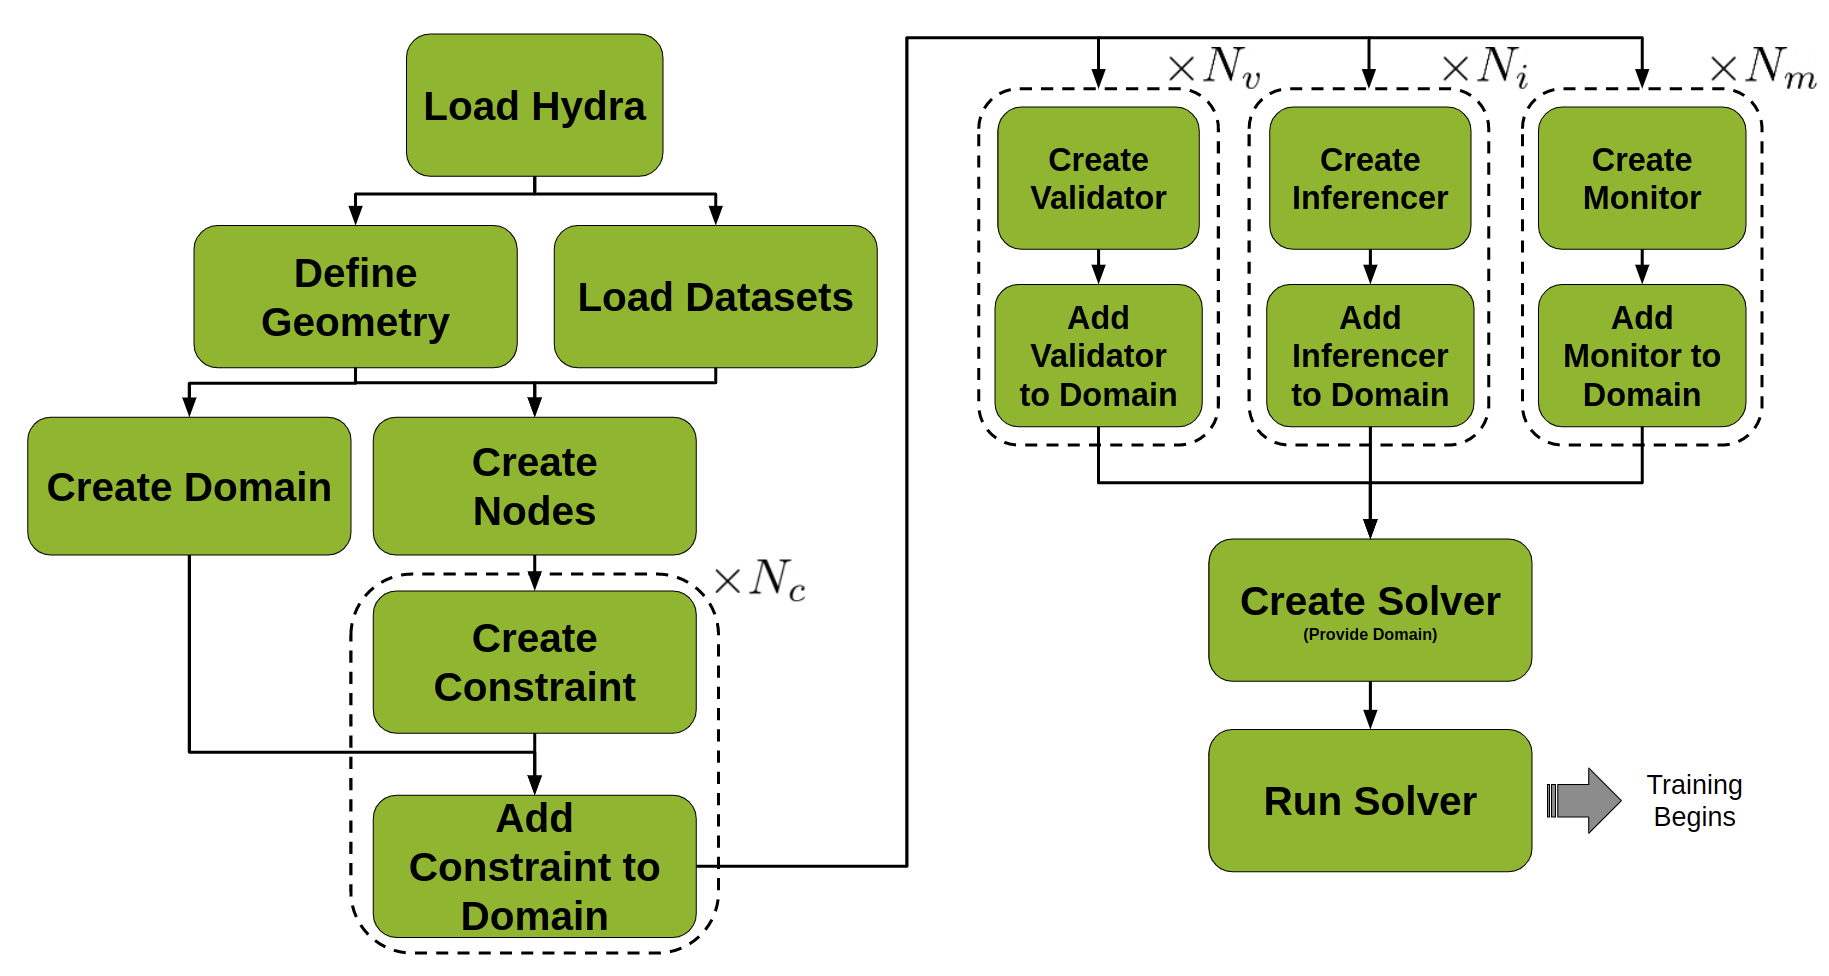

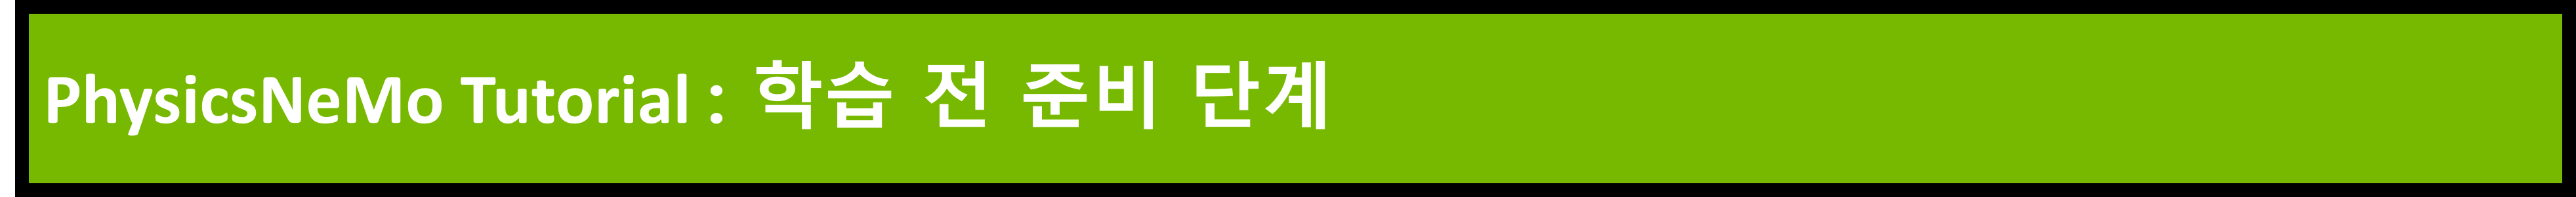

### 라이브러리 설치

In [2]:
!pip uninstall -y nvidia-physicsnemo fsspec s3fs
!pip install "fsspec==2025.3.0" "s3fs==2025.3.0" "gcsfs==2025.3.0" "jedi>=0.16"
!pip install --no-deps "nvidia-physicsnemo==1.2.0"
!pip install -U hydra-core==1.3.2 omegaconf==2.3.0
!pip install mlflow
!pip install nvidia-physicsnemo-sym --no-build-isolation
#!pip install --no-deps "nvidia-physicsnemo-sym==2.2.0"

Found existing installation: fsspec 2025.3.0
Uninstalling fsspec-2025.3.0:
  Successfully uninstalled fsspec-2025.3.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 137.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 2.0.0
    Uninstalling wrapt-2.0.0:
      Successfully uninstalled wrapt-2.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.0/806.0 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 132.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

In [3]:
# NVIDIA DALI 자동 설치 (CUDA 버전 감지 → 맞는 휠 설치)
import re, sys, subprocess

def detect_cuda_major():
    # 1) PyTorch가 있으면 그 버전으로 우선 판별
    try:
        import torch
        v = torch.version.cuda or ""
        m = re.match(r"(\d+)\.(\d+)", v)
        if m:
            return int(m.group(1))
    except Exception:
        pass
    # 2) nvidia-smi 출력에서 "CUDA Version: xx.x" 파싱 (드라이버 기준)
    try:
        out = subprocess.check_output(["nvidia-smi"], text=True, stderr=subprocess.STDOUT)
        m = re.search(r"CUDA Version:\s*([0-9]+)\.", out)
        if m:
            return int(m.group(1))
    except Exception:
        pass
    return 12  # Colab 기본 가정 (12.x)

major = detect_cuda_major()
if   major >= 13: pkg = "nvidia-dali-cuda130"
elif major == 12: pkg = "nvidia-dali-cuda120"
elif major == 11: pkg = "nvidia-dali-cuda110"
else:             pkg = "nvidia-dali-cuda120"  # 합리적 기본값

print(f"Installing: {pkg}")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", pkg])

# 설치 확인
import nvidia.dali as dali
print("DALI OK — version:", dali.__version__)

Installing: nvidia-dali-cuda120
DALI OK — version: 1.52.0


In [4]:
!git clone https://github.com/heechangkim/physicsnemo_tutorial.git

Cloning into 'physicsnemo_tutorial'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 142 (delta 21), reused 43 (delta 11), pack-reused 86 (from 1)
Receiving objects: 100% (142/142), 236.35 MiB | 16.11 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Updating files: 100% (56/56), done.


In [5]:
# --- 강제 로깅 초기화(중복 핸들러 방지, 레벨 보장) ---
import logging
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(name)s: %(message)s', force=True)
for name in ["physicsnemo", "physicsnemo.sym", "physicsnemo.sym.trainer"]:
    logging.getLogger(name).setLevel(logging.INFO)

In [6]:
from hydra.utils import to_absolute_path
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf, open_dict

%cd /content/physicsnemo_tutorial/PINNs/basic_examples/conf/
%mkdir /tmp/conf

/content/physicsnemo_tutorial/PINNs/basic_examples/conf


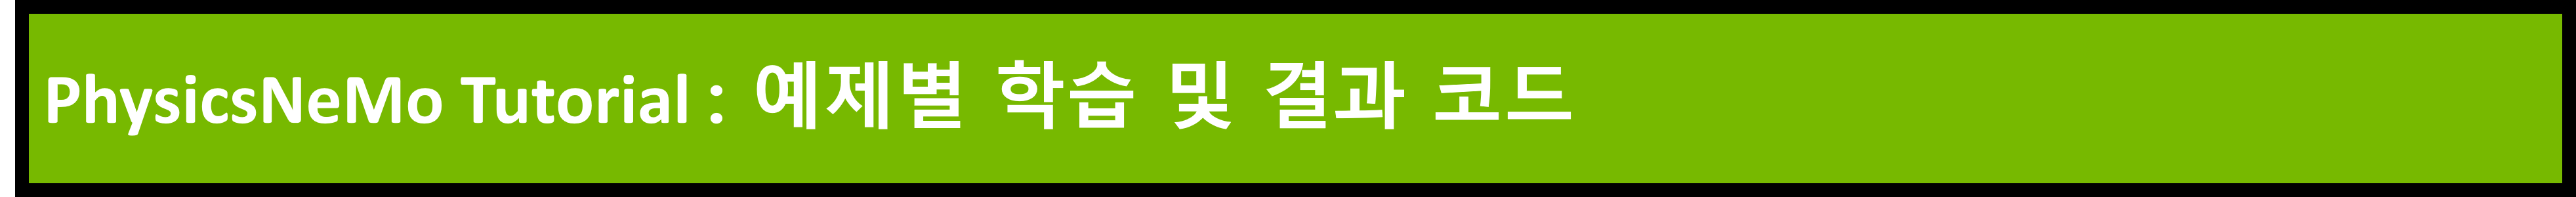

# 1D Function Regression Problem
다음의 1차원 함수에 대해 Regression 문제를 해결합니다.
$$u(x) = 5\sin(\pi x) +\sin(8\pi x)+0.5\sin(16\pi x),x\in[-1,1].$$
Given a set of N training data ${x_i, u_i}_{i=1}^N$ where $u_i=u(x_i)$, train a neural network to approximate $u(x)$.

이 예제는 다음 내용을 실습합니다.
- PhysicsNeMo 모델 학습 Workflow (기본)
- Spectral bias
- Fourier Feature Embedding method의 학습 가속 효과


## Fourier Feature Embedding이란?
### Spectral Bias
- 일반 MLP는 저주파 -> 고주파 순서로 학습이 됩니다.
- 수식 $u(x)$로 설명하자면,
$$\sin(\pi x) \rightarrow \sin(8\pi x) \rightarrow \sin(16\pi x)$$
순서로 학습되는 모습을 관찰할 수 있습니다.
- 실험 1에서 다룹니다.

### Fourier Feature Embedding
- 입력 x를 다음과 같이 변환합니다.
$$ \phi(x) = [\sin(2\pi Bx),\cos(2\pi Bx)] $$
- 다양한 주파수 기저 위에서 선형 결합만을 학습하도록 하여 수렴 속도를 가속화 합니다.
- 실험 2에서 다룹니다.

### FFE hyperparameter
- m : 특징 수
  - 값이 크면 표현력이 올라가지만 computational cost가 상승하는 trade-off가 발생합니다.
- scale :주파수 폭
  - 랜덤 주파수 $B$에 대해서
  - $B \sim N(0, scale^2)$

In [59]:
import math, time, random, os, shutil
import numpy as np
import torch
import matplotlib.pyplot as plt
from omegaconf import open_dict

from physicsnemo.sym.domain.constraint import PointwiseConstraint
from physicsnemo.sym.domain import Domain
from physicsnemo.sym.solver import Solver

random.seed(42); np.random.seed(42); torch.manual_seed(42); torch.cuda.manual_seed_all(42)

In [60]:
def snapshot_and_predict(step:int, cfg, invar_test, net_factory, fname="u_network.0.pth"):
    """현재 network_dir의 *.pth를 ckpt_step_{step} 하위 폴더로 복사하고,
       거기서 모델을 로드해 예측을 npz로 저장한 뒤 numpy 예측을 반환합니다.
    """
    base = cfg.network_dir
    snap_dir = os.path.join(base, f"ckpt_step_{step:06d}")
    os.makedirs(snap_dir, exist_ok=True)

    # 현재 network_dir의 체크포인트 파일 복사
    for fn in os.listdir(base):
        if fn.endswith(".pth"):
            shutil.copy2(os.path.join(base, fn), os.path.join(snap_dir, fn))

    # 예측
    net_eval = _new_baseline_net()  # 같은 아키텍처의 fresh 모델 생성
    ckpt_path = os.path.join(snap_dir, fname)
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"checkpoint not found: {ckpt_path}")
    net_eval.load_state_dict(torch.load(ckpt_path, map_location="cpu"))
    net_eval.eval()
    with torch.no_grad():
        xt = torch.from_numpy(invar_test["x"]).float()
        pred = net_eval({"x": xt})["u"].cpu().numpy().reshape(-1)

    # npz 저장
    np.savez(os.path.join(snap_dir, f"pred_step_{step:06d}.npz"),
             x=invar_test["x"], u_pred=pred)
    return pred, snap_dir

### Define Problem

##### function u(x)

In [61]:
def target_function_np(x: np.ndarray) -> np.ndarray:
    return 5*np.sin(np.pi*x) + np.sin(8*np.pi*x) + 0.5*np.sin(16*np.pi*x)

### Load Configuration

In [62]:
# 1D Regression 학습 hyperparameter setting 파일(configuration 파일) 불러오기
%cd /content/physicsnemo_tutorial/PINNs/basic_examples/conf/
%mkdir /tmp/conf
%cp config_1D_Regression.yaml /tmp/conf
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()
initialize(version_base="1.3", config_path="conf")
config_name = "config_1D_Regression"
cfg = compose(config_name=config_name)

/content/physicsnemo_tutorial/PINNs/basic_examples/conf
mkdir: cannot create directory ‘/tmp/conf’: File exists


### Define Dataset

In [63]:
# cfg.data.* 사용 (없으면 기본값으로 대체)

# x 범위 설정
x_min = float(getattr(getattr(cfg, "data", {}), "x_min", -1.0))
x_max = float(getattr(getattr(cfg, "data", {}), "x_max",  1.0))

# training data, test data point 개수 설정
num_train = int(getattr(getattr(cfg, "data", {}), "num_train", 100))
num_test  = int(getattr(getattr(cfg, "data", {}), "num_test",  1000))

# train dataset 생성
x_train = np.linspace(x_min, x_max, num_train, dtype=np.float32)
y_train = target_function_np(x_train).astype(np.float32)

# test dataset 생성
x_test  = np.linspace(x_min, x_max, num_test,  dtype=np.float32)
y_test  = target_function_np(x_test).astype(np.float32)

invar_train = {"x": x_train.reshape(-1,1)}
outvar_train = {"u": y_train.reshape(-1,1)}
invar_test  = {"x": x_test.reshape(-1,1)}

dataset_size = invar_train["x"].shape[0]   # = num_train
bs_cfg = getattr(getattr(cfg, "batch_size", {}), "data", dataset_size)
batch_size_data = int(max(1, min(bs_cfg, dataset_size)))
print(f"[check] dataset_size={dataset_size}, batch_size_data={batch_size_data}")
assert batch_size_data <= dataset_size, "batch_size.data must be <= num_train"

[check] dataset_size=100, batch_size_data=100


### Define Model

- physicsnemo의 fullyconnected MLP architecture를 불러와서 사용합니다.

In [64]:
from physicsnemo.sym.key import Key
from physicsnemo.sym.models.fully_connected import FullyConnectedArch
from physicsnemo.sym.models.activation import Activation

In [65]:
# network 생성 함수
def _new_baseline_net():
    return FullyConnectedArch(
        input_keys=[Key("x")],
        output_keys=[Key("u")],
        nr_layers=cfg.arch.fully_connected.nr_layers,
        layer_size=cfg.arch.fully_connected.layer_size,
        activation_fn=cfg.arch.activation_fn,
    )

## 실험 1 Spectral Bias

### Spectral Bias
- MLP는 저주파 -> 고주파 순서로 학습됩니다.
- $\sin(\pi x) \rightarrow \sin(8\pi x) \rightarrow \sin(16\pi x)$
순서로 학습되는 모습을 관찰할 수 있습니다.

### Solver로 모델 학습 하기
##### PhysicsNeMo Solver를 이용해 모델을 학습하기 위해서 다음과 같은 과정이 필요합니다.
- 모델 네트워크 선언
  - 원하는 setting의 모델 네트워크를 선언합니다.
- Node 정의
  - node에 모델 네트워크를 등록합니다.
- 학습 constraint 정의
  - node, dataset을 constraint에 같이 등록합니다.
- domain 정의
  - domain에 constraint를 전달합니다.
- solver 정의
  - solver에 configuration 파일과 domain을 전달합니다.

### hyperparameter setting
configuration을 통해 hyperparamter를 setting할 수 있습니다.
- max_steps : 총 학습 횟수 (epochs)
- layer_size : 네트워크 너비
- nr_layers : 네트워크 layer 개수
- actv_fn : activation function
- model_name : 저장할 폴더

##### 주의사항 : 세팅을 바꾸어 실험을 진행할때
- 모델 저장을 덮어 씌우지 않도록 폴더명을 바꾸어 주어야 합니다.
- 반드시 순서대로 진행해야 합니다.
  1. cfg에 하이퍼파라미터 등록
  2. 모델 생성
  3. node / constraint / domain 정의
  4. solver 생성 및 학습 진행

In [71]:
model_name = "baseline_A"

with open_dict(cfg):
    cfg.training.max_steps = 10000
    cfg.arch.fully_connected.layer_size = 50
    cfg.arch.fully_connected.nr_layers = 2
    cfg.arch.activation_fn = Activation.TANH ## TANH, SILU, SIN, RELU, GELU, LEAKY_RELU, ...
    cfg.network_dir = os.path.join("outputs", model_name)  # 하위 폴더 구분


##### model 생성

In [72]:
net = _new_baseline_net()

##### node / constraint / domain

In [73]:
# node 정의
nodes = [net.make_node(name="u_network")]

# 학습 constraint 정의
data_con = PointwiseConstraint.from_numpy(
    nodes=nodes, invar=invar_train, outvar=outvar_train, batch_size=batch_size_data
)

# domain 정의
domain = Domain()
domain.add_constraint(data_con, "data")

##### Create Solver

- spectral bias를 비교하기 위한 실험을 진행합니다.
- 1000,3000,10000 epoch 에서의 모델 결과를 저장하고 비교합니다.

In [74]:
# 타깃 스텝들에서 재개 학습 → 스냅샷/예측
preds_spec = {}
target_steps = [1000, 3000, 10000] # 저장할 epoch 값

for tgt in target_steps:
    with open_dict(cfg):
        cfg.training.max_steps = int(tgt)

    slv = Solver(cfg, domain)
    slv.solve()

    pred, snap_dir = snapshot_and_predict(tgt, cfg, invar_test, _new_baseline_net)
    preds_spec[tgt] = pred
    print(f"[info] snapshot+pred saved @ {tgt} → {snap_dir}")


/usr/local/lib/python3.12/dist-packages/physicsnemo/sym/amp.py:219: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  super().__init__(*args, **kwargs)
[INFO] physicsnemo.sym.trainer: attempting to restore from: /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/baseline_A
[WARNING] physicsnemo.sym.trainer: optimizer checkpoint not found
[WARNING] physicsnemo.sym.trainer: model u_network.0.pth not found
[INFO] physicsnemo.sym.trainer: [step:          0] record constraint batch time:  4.268e-03s
[INFO] physicsnemo.sym.trainer: [step:          0] saved checkpoint to /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/baseline_A
[INFO] physicsnemo.sym.trainer: [step:          0] loss:  1.315e+03
[INFO] physicsnemo.sym.trainer: [step:        100] loss:  2.021e+02, time/iteration:  3.926e+00 ms
[INFO] physicsnemo.sym.trainer: [step:        200] loss:  8.891e+01, time/iteration:  3.736e+00

[info] snapshot+pred saved @ 1000 → outputs/baseline_A/ckpt_step_001000


[INFO] physicsnemo.sym.trainer: [step:       1100] loss:  4.533e+01, time/iteration:  5.398e+00 ms
[INFO] physicsnemo.sym.trainer: [step:       1200] loss:  3.852e+01, time/iteration:  4.256e+00 ms
[INFO] physicsnemo.sym.trainer: [step:       1300] loss:  3.192e+01, time/iteration:  3.837e+00 ms
[INFO] physicsnemo.sym.trainer: [step:       1400] loss:  2.546e+01, time/iteration:  4.004e+00 ms
[INFO] physicsnemo.sym.trainer: [step:       1500] loss:  1.976e+01, time/iteration:  3.808e+00 ms
[INFO] physicsnemo.sym.trainer: [step:       1600] loss:  1.577e+01, time/iteration:  3.892e+00 ms
[INFO] physicsnemo.sym.trainer: [step:       1700] loss:  1.326e+01, time/iteration:  3.989e+00 ms
[INFO] physicsnemo.sym.trainer: [step:       1800] loss:  1.179e+01, time/iteration:  3.827e+00 ms
[INFO] physicsnemo.sym.trainer: [step:       1900] loss:  1.053e+01, time/iteration:  3.777e+00 ms
[INFO] physicsnemo.sym.trainer: [step:       2000] record constraint batch time:  3.502e-03s
[INFO] physicsne

[info] snapshot+pred saved @ 3000 → outputs/baseline_A/ckpt_step_003000


[INFO] physicsnemo.sym.trainer: [step:       3100] loss:  5.346e+00, time/iteration:  3.811e+00 ms
[INFO] physicsnemo.sym.trainer: [step:       3200] loss:  5.053e+00, time/iteration:  3.969e+00 ms
[INFO] physicsnemo.sym.trainer: [step:       3300] loss:  4.789e+00, time/iteration:  3.973e+00 ms
[INFO] physicsnemo.sym.trainer: [step:       3400] loss:  4.558e+00, time/iteration:  3.833e+00 ms
[INFO] physicsnemo.sym.trainer: [step:       3500] loss:  4.353e+00, time/iteration:  3.946e+00 ms
[INFO] physicsnemo.sym.trainer: [step:       3600] loss:  4.174e+00, time/iteration:  3.870e+00 ms
[INFO] physicsnemo.sym.trainer: [step:       3700] loss:  4.007e+00, time/iteration:  4.462e+00 ms
[INFO] physicsnemo.sym.trainer: [step:       3800] loss:  3.864e+00, time/iteration:  4.925e+00 ms
[INFO] physicsnemo.sym.trainer: [step:       3900] loss:  3.735e+00, time/iteration:  4.707e+00 ms
[INFO] physicsnemo.sym.trainer: [step:       4000] record constraint batch time:  4.963e-03s
[INFO] physicsne

[info] snapshot+pred saved @ 10000 → outputs/baseline_A/ckpt_step_010000


### 학습 결과 플롯
- Spectral bias 비교 플롯입니다.
- 다음 4개를 비교합니다.
  - y_test (정답곡선)
  - 1000epoch 학습 결과
  - 3000epoch 학습 결과
  - 10000epoch 학습 결과
- 학습이 진행됨에 따라 저주파에서 고주파로 학습이 진행되는 Spectral bias를 확인할 수 있습니다.


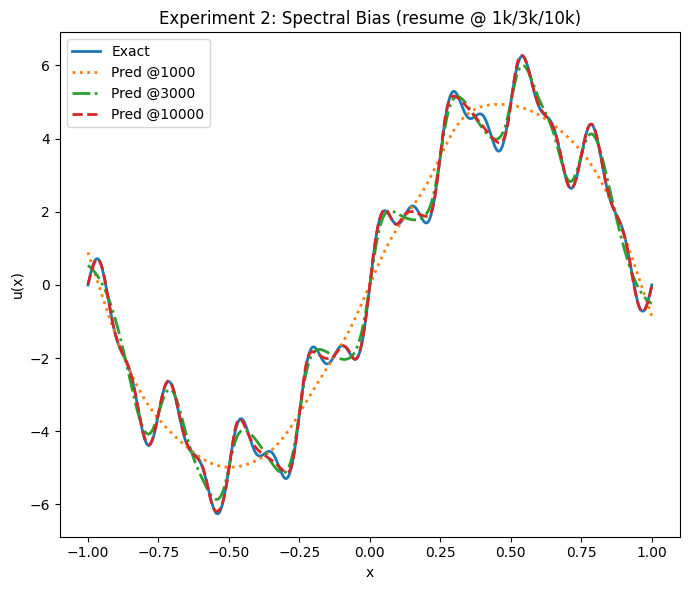

In [75]:
# 비교 플롯
styles = {1000:":", 3000:"-.", 10000:"--"}
plt.figure(figsize=(7,6))
plt.plot(x_test, y_test, lw=2, label="Exact")
for s in sorted(preds_spec.keys()):
    plt.plot(x_test, preds_spec[s], styles.get(s, "--"), lw=2, label=f"Pred @{s}")
plt.xlabel("x"); plt.ylabel("u(x)")
plt.title("Experiment 2: Spectral Bias (resume @ 1k/3k/10k)")
plt.legend(loc="upper left"); plt.tight_layout(); plt.show()

## 실험 2 Fourier Feature Embedding

##### FFE를 통한 수렴 속도 향상을 확인합니다.
- 앞서 실험 1에서 10000epoch에 고주파까지 학습이 완료됨을 확인했습니다.
- 이번 실험에서는 FFE를 적용하여 1000epoch 까지만 학습하더라도 고주파까지 학습이 완료됨을 확인할 수 있습니다.

### Fourier Feature Embedding
$$ \phi(x) = [\sin(2\pi Bx),\cos(2\pi Bx)] $$

### FFE hyperparameter
- m : 특징 수
- scale :주파수 폭
$$B \sim N(0, scale^2)$$

### FFE 실험 Hyperparameter 정의
- 주의사항 : 새로운 세팅으로 실험을 진행할때
  - model name (모델 저장 폴더) 를 변경하세요
  - hyperparameter setting을 변경하세요
  - 반드시 다음의 코드 블록을 모두 순서대로 실행해야 합니다.


In [20]:
m = 10
scale = 3.0
model_name = "fourier_m10_scale3"
training_step_ffe = 1000

### Define Model

In [21]:
torch.manual_seed(42)
## 행렬 B를 정의합니다.
B = (scale * torch.randn(1, m)).cpu().numpy().astype(np.float32)    # [1, m]

## xB를 계산해 각 데이터를 m개의 주파수 차원으로 projection 합니다.
xtr = x_train.reshape(-1,1).astype(np.float32)            # (N,1)
xte = x_test.reshape(-1,1).astype(np.float32)
proj_tr = 2*np.pi * (xtr @ B)   # (N, m)
proj_te = 2*np.pi * (xte @ B)


invar_train_ff = {}
invar_test_ff  = {}

## 최종 입력 채널 수는 2m입니다.
## 모델 입력을 Key 형태로 구성합니다.
for i in range(m):
    invar_train_ff[f"ff_sin_{i}"] = np.sin(proj_tr[:, i:i+1])
    invar_test_ff[f"ff_sin_{i}"]  = np.sin(proj_te[:, i:i+1])
for i in range(m):
    invar_train_ff[f"ff_cos_{i}"] = np.cos(proj_tr[:, i:i+1])
    invar_test_ff[f"ff_cos_{i}"]  = np.cos(proj_te[:, i:i+1])

## FFE Network: 입력 Key = ff_sin_i + ff_cos_i
ffe_keys = [Key(f"ff_sin_{i}") for i in range(m)] + [Key(f"ff_cos_{i}") for i in range(m)]

In [22]:
## 앞서 정의한 key를 통해 모델의 입력을 정의합니다.
def _new_ffe_net():
    return FullyConnectedArch(
        input_keys=ffe_keys,
        output_keys=[Key("u")],
        nr_layers=2,
        layer_size=50,
        activation_fn=Activation.TANH,
    )

random.seed(42); np.random.seed(42); torch.manual_seed(42); torch.cuda.manual_seed_all(42)

In [23]:
with open_dict(cfg):
    cfg.training.max_steps = training_step_ffe
    cfg.network_dir = os.path.join("outputs", model_name)
    os.makedirs(cfg.network_dir, exist_ok=True)
    np.save(os.path.join(cfg.network_dir, "B.npy"), B)

In [24]:
net = _new_ffe_net()

### Nodes, Constraint, Domain

In [25]:
nodes = [net.make_node(name="u_network")]

data_con = PointwiseConstraint.from_numpy(
    nodes=nodes, invar=invar_train_ff, outvar=outvar_train, batch_size=batch_size_data
)
domain = Domain()
domain.add_constraint(data_con, "data")

### Create Solver

In [26]:
slv = Solver(cfg, domain)
slv.solve()

[INFO] physicsnemo.sym.trainer: attempting to restore from: /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/fourier_m10_scale3
[WARNING] physicsnemo.sym.trainer: optimizer checkpoint not found
[WARNING] physicsnemo.sym.trainer: model u_network.0.pth not found
[INFO] physicsnemo.sym.trainer: [step:          0] record constraint batch time:  7.299e-03s
[INFO] physicsnemo.sym.trainer: [step:          0] saved checkpoint to /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/fourier_m10_scale3
[INFO] physicsnemo.sym.trainer: [step:          0] loss:  1.467e+03
[INFO] physicsnemo.sym.trainer: [step:        100] loss:  3.976e-01, time/iteration:  4.980e+00 ms
[INFO] physicsnemo.sym.trainer: [step:        200] loss:  5.412e-02, time/iteration:  4.961e+00 ms
[INFO] physicsnemo.sym.trainer: [step:        300] loss:  2.575e-02, time/iteration:  4.876e+00 ms
[INFO] physicsnemo.sym.trainer: [step:        400] loss:  2.222e-02, time/iteration:  4.983e+00 ms
[INFO] physic

### 학습 결과

### 학습 결과 플롯
- Spectral bias 비교 플롯입니다.
- 다음 2개를 비교합니다.
  - y_test (정답곡선)
  - FFE 1000epoch 학습 결과
- 실험 1과 달리 1000epoch에서도 고주파 성분까지 완벽히 학습된것을 확인할 수 있습니다.
- FFE를 통해 Spectral bias를 해소함을 확인할 수 있습니다.


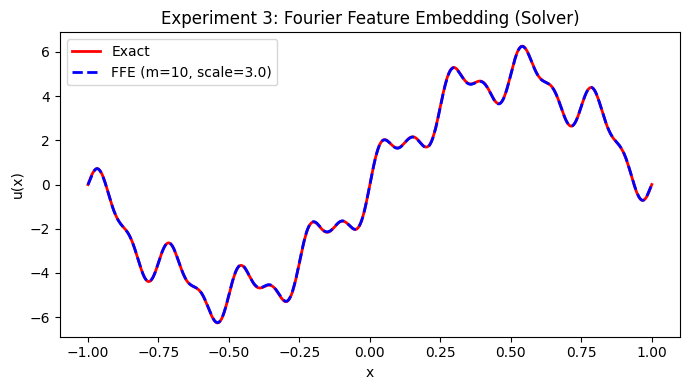

In [27]:
# 체크포인트 로드 & 예측
net_star = _new_ffe_net()
ckpt_path = os.path.join(cfg.network_dir, "u_network.0.pth")
net_star.load_state_dict(torch.load(ckpt_path, map_location="cpu"))
net_star.eval()

with torch.no_grad():
    invar_test_ff_torch = {k: torch.from_numpy(v).float() for k, v in invar_test_ff.items()}
    pred_ff = net_star(invar_test_ff_torch)["u"].cpu().numpy().reshape(-1)

# 플롯
plt.figure(figsize=(7,4))
plt.plot(x_test, y_test, 'r', lw=2, label='Exact')
plt.plot(x_test, pred_ff, 'b--', lw=2, label=f'FFE (m={m}, scale={scale})')
plt.xlabel('x'); plt.ylabel('u(x)')
plt.title('Experiment 3: Fourier Feature Embedding (Solver)')
plt.legend(); plt.tight_layout(); plt.show()

# 2D Function Regression Problem
다음 2차원 함수에 대해 Regression 문제를 해결합니다.
$$ u(x_1,x_2) = x_1 x_2 \sqrt{|\cos(\pi x_1) \cos(\pi x_2)|}, \qquad (x_1,x_2) \in [50,54]^2. $$

Given a set of $N$ training data $\{X^i,u^i\}_{i=1}^N$, where $X^i=(x_1^i,x_2^i)$ and $u^i=u(x_1^i,x_2^i)$, train a neural network to approximate $u(x_1,x_2)$.

### Baseline 학습 (실험 1) 과 데이터 정규화 학습 (실험 2)를 비교합니다.
- 모델 학습에서 정규화가 미치는 영향을 배웁니다.
- 정규화를 통해 성능이 개선됨을 확인할 수 있습니다.
- z-정규화를 사용합니다 : $Z=(X-\mu)/\sigma$

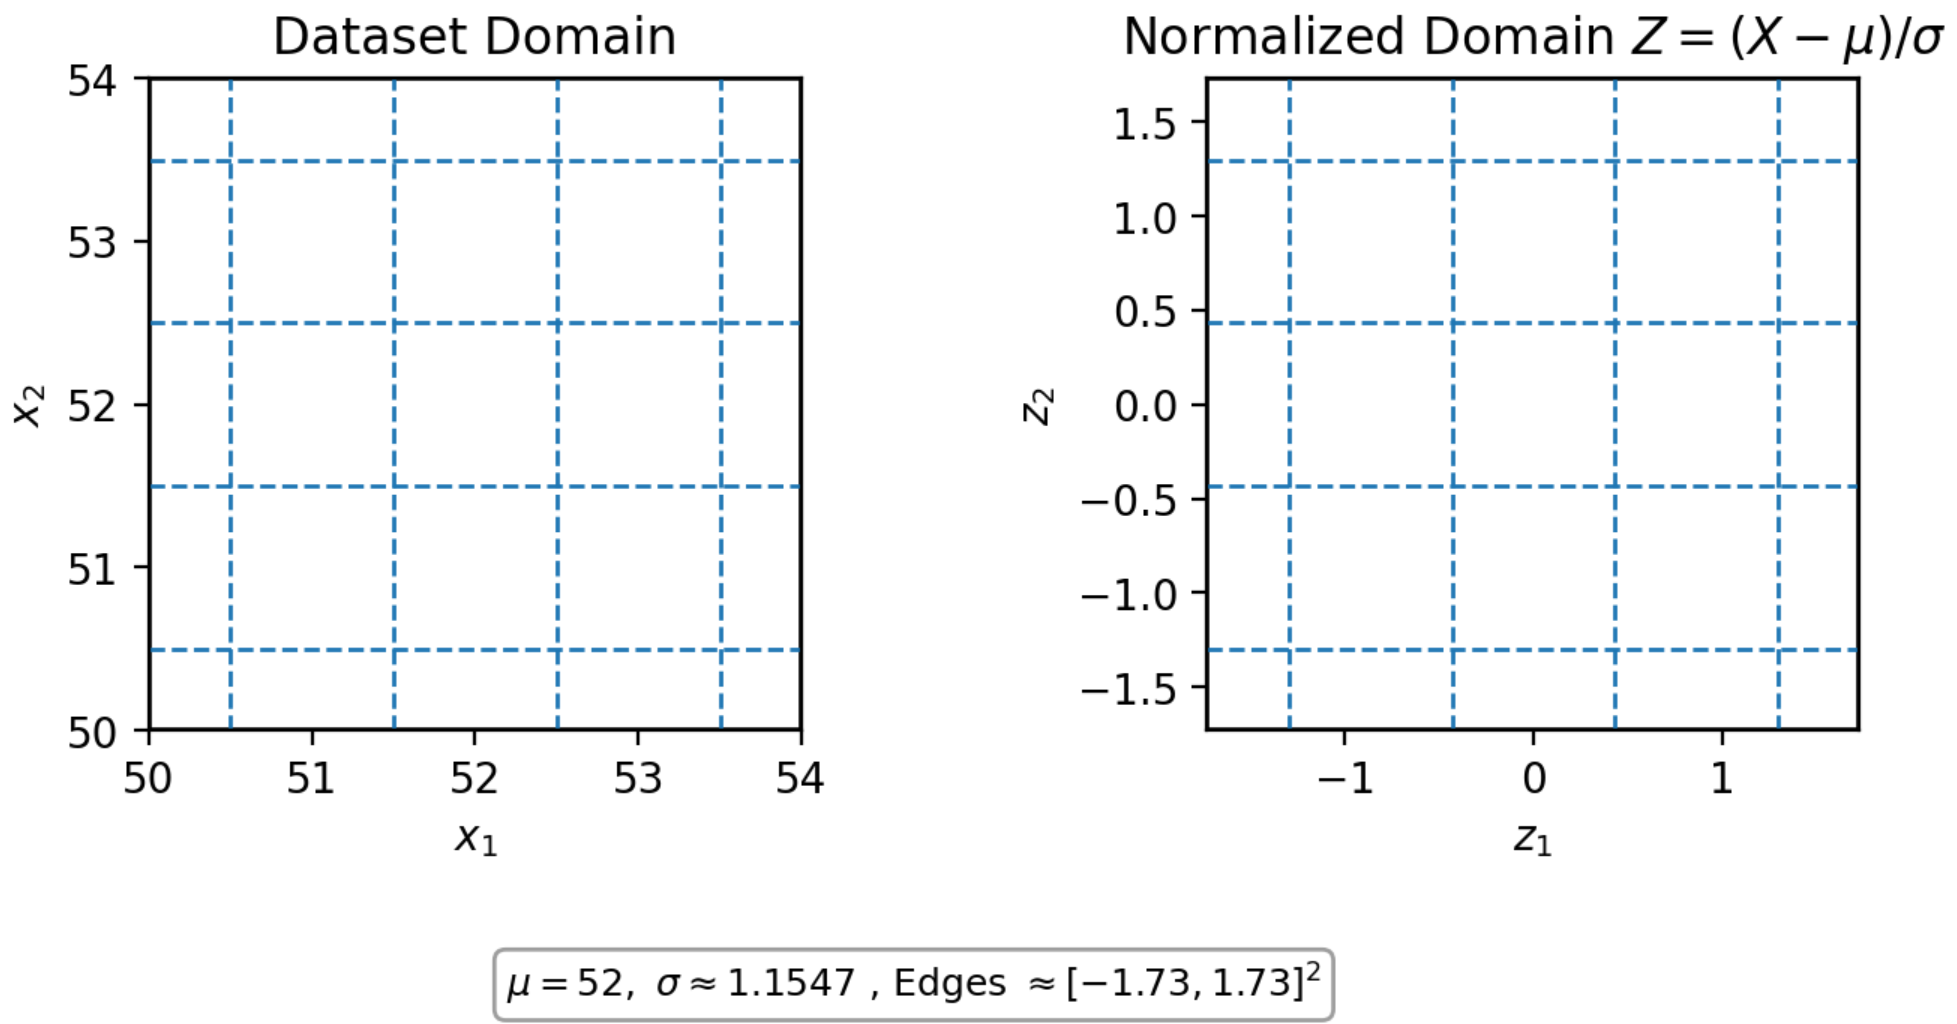

In [28]:
#%% Regression 2D — 데이터 샘플링(GeometryDatapipe) + 테스트 그리드 준비
import numpy as np, torch
from physicsnemo.sym.domain.constraint import PointwiseConstraint
from physicsnemo.sym.domain import Domain
from physicsnemo.sym.solver import Solver
from omegaconf import open_dict
import os, torch
import matplotlib.pyplot as plt
from physicsnemo.sym.geometry.primitives_2d import Rectangle
from physicsnemo.sym.geometry.geometry_dataloader import GeometryDatapipe
import math

from physicsnemo.sym.key import Key
from physicsnemo.sym.models.activation import Activation
from physicsnemo.sym.models.fully_connected import FullyConnectedArch

### Define Problem

In [29]:
def target_function_np(x1, x2):
    return x1 * x2 * np.sqrt(np.abs(np.cos(np.pi * x1) * np.cos(np.pi * x2)))
def target_function_torch(x1, x2):
    return x1 * x2 * torch.sqrt(torch.abs(torch.cos(math.pi * x1) * torch.cos(math.pi * x2)))

### Load Configuration

In [30]:
%cd /content/physicsnemo_tutorial/PINNs/basic_examples/conf/
%mkdir /tmp/conf
%cp config_2D_Regression.yaml /tmp/conf
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()
initialize(version_base="1.3", config_path="conf")
config_name = "config_2D_Regression"
cfg = compose(config_name=config_name)

/content/physicsnemo_tutorial/PINNs/basic_examples/conf
mkdir: cannot create directory ‘/tmp/conf’: File exists


### Define Geometry, Dataset, model

In [31]:
# 2D 도메인에서 PN으로 N개 샘플
N = int(getattr(getattr(cfg, "data", {}), "N", 4000))
x_min = float(getattr(getattr(cfg, "data", {}), "x_min", 50.0))
x_max = float(getattr(getattr(cfg, "data", {}), "x_max", 54.0))
grid_n = int(getattr(getattr(cfg, "data", {}), "grid_n", 100))

rec = Rectangle((x_min, x_min), (x_max, x_max))
train_dp = GeometryDatapipe(
    geom_objects=[rec],
    batch_size=1,
    num_points=N,
    sample_type="volume",
    device="cpu",
    num_workers=1,
    requested_vars=["x", "y"],
)

batch = next(iter(train_dp))[0]
x1_t = batch["x"].reshape(-1, 1)   # torch (N,1)
x2_t = batch["y"].reshape(-1, 1)   # torch (N,1)
X_t  = torch.cat([x1_t, x2_t], dim=1)              # torch (N,2)
y_t  = target_function_torch(x1_t, x2_t)           # torch (N,1)

/usr/local/lib/python3.12/dist-packages/nvidia/dali/plugin/base_iterator.py:208: Warning: Please set `reader_name` and don't set last_batch_padded and size manually whenever possible. This may lead, in some situations, to missing some samples or returning duplicated ones. Check the Sharding section of the documentation for more details.
  _iterator_deprecation_warning()


In [32]:
# 테스트 격자
x1_test = np.linspace(x_min, x_max, grid_n, dtype=np.float32)
x2_test = np.linspace(x_min, x_max, grid_n, dtype=np.float32)
X1g, X2g = np.meshgrid(x1_test, x2_test, indexing="xy")
X_test = np.stack([X1g.ravel(), X2g.ravel()], axis=1).astype(np.float32)
Y_exact = target_function_np(X1g, X2g)

# from_numpy용 dict (A run)
invar_train_2d = {"x": x1_t.cpu().numpy(), "y": x2_t.cpu().numpy()}
outvar_train_2d = {"u": y_t.cpu().numpy()}
invar_test_2d = {"x": X_test[:, 0:1], "y": X_test[:, 1:2]}

# 배치=전량 (안전 클램프)
dataset_size = invar_train_2d["x"].shape[0]
batch_size_data = dataset_size
print(f"[2D] dataset_size={dataset_size}, batch_size_data={batch_size_data}")

[2D] dataset_size=4000, batch_size_data=4000


In [33]:
#%% Regression 2D — 공통: 네트워크/노드 정의
def _new_reg2d_net():
    return FullyConnectedArch(
        input_keys=[Key("x"), Key("y")],
        output_keys=[Key("u")],
        nr_layers=cfg.arch.fully_connected.nr_layers,
        layer_size=cfg.arch.fully_connected.layer_size,
        activation_fn=cfg.arch.fully_connected.activation_fn,
    )

## 실험 1 Baseline

정규화 실험과 (실험2)와 비교를 위한 Baseline 실험입니다.

domain : $\qquad (x_1,x_2) \in [50,54]^2. $


### hyperparameter setting


- 주의사항 : 새로운 세팅으로 실험을 진행할때
  - model name (모델 저장 폴더) 를 변경하세요
  - hyperparameter setting을 변경하세요
  - 반드시 다음의 코드 블록을 모두 순서대로 실행해야 합니다.

In [34]:
model_name = "reg2d_A"
ex1_epochs = 10000

with open_dict(cfg):
    cfg.network_dir = os.path.join("outputs", model_name)
    cfg.training.max_steps = ex1_epochs
    cfg.arch.fully_connected.layer_size = 50
    cfg.arch.fully_connected.nr_layers = 3
    cfg.arch.fully_connected.activation_fn = Activation.TANH

In [35]:
net = _new_reg2d_net()

### Define Node, Constraint, Domain

In [36]:
nodes = [net.make_node("u_network")]
data_con = PointwiseConstraint.from_numpy(nodes=nodes, invar=invar_train_2d,
                                          outvar=outvar_train_2d, batch_size=batch_size_data)
domain = Domain()
domain.add_constraint(data_con, "data")

### Create Solver

In [37]:
slv = Solver(cfg, domain)
slv.solve()

[INFO] physicsnemo.sym.trainer: attempting to restore from: /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/reg2d_A
[WARNING] physicsnemo.sym.trainer: optimizer checkpoint not found
[WARNING] physicsnemo.sym.trainer: model u_network.0.pth not found
[INFO] physicsnemo.sym.trainer: [step:          0] record constraint batch time:  1.413e-02s
[INFO] physicsnemo.sym.trainer: [step:          0] saved checkpoint to /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/reg2d_A
[INFO] physicsnemo.sym.trainer: [step:          0] loss:  1.198e+10
[INFO] physicsnemo.sym.trainer: [step:        100] loss:  1.178e+10, time/iteration:  7.977e+00 ms
[INFO] physicsnemo.sym.trainer: [step:        200] loss:  1.171e+10, time/iteration:  8.009e+00 ms
[INFO] physicsnemo.sym.trainer: [step:        300] loss:  1.165e+10, time/iteration:  7.890e+00 ms
[INFO] physicsnemo.sym.trainer: [step:        400] loss:  1.158e+10, time/iteration:  7.790e+00 ms
[INFO] physicsnemo.sym.trainer: [st

### 학습 결과
- 정답값과 모델 예측값을 비교합니다.
- 정규화 하지 않은 Baseline 모델은 예측에 실패한것을 확인할 수 있습니다.

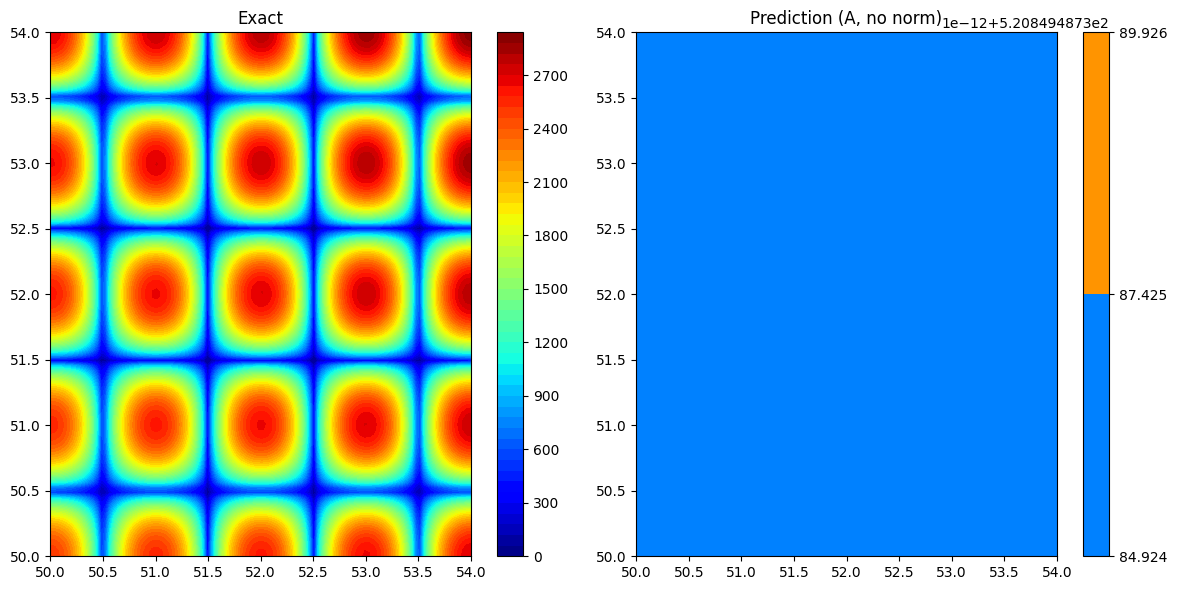

In [38]:
# 체크포인트 로드→테스트 예측
net_A = _new_reg2d_net()
ckpt_A = os.path.join(cfg.network_dir, "u_network.0.pth")
net_A.load_state_dict(torch.load(ckpt_A, map_location="cpu"))
net_A.eval()
with torch.no_grad():
    X1 = torch.from_numpy(invar_test_2d["x"]).float()
    X2 = torch.from_numpy(invar_test_2d["y"]).float()
    Yp_A = net_A({"x": X1, "y": X2})["u"].cpu().numpy().reshape(X1g.shape)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.contourf(X1g, X2g, Y_exact, levels=50, cmap="jet"); plt.colorbar(); plt.title("Exact")
plt.subplot(1,2,2); plt.contourf(X1g, X2g, Yp_A,   levels=50, cmap="jet"); plt.colorbar(); plt.title("Prediction (A, no norm)")
plt.tight_layout(); plt.show()

## 실험 2. normalization (정규화)

### z-정규화 진행
- dataset에 z-정규화를 적용합니다.
$$Z=(X-\mu)/\sigma$$

In [39]:
#%% Regression 2D — 실험 B: 입력/출력 정규화
import numpy as np

X_np = X_t.cpu().numpy()                   # (N,2)
y_np = y_t.cpu().numpy()                   # (N,1)
X_mean = X_np.mean(axis=0, keepdims=True)
X_std  = X_np.std(axis=0, keepdims=True) + 1e-12
y_mean = y_np.mean(keepdims=True)
y_std  = y_np.std(keepdims=True) + 1e-12

# 정규화
invar_train_2d_B = {
    "x": ((X_np[:, 0:1] - X_mean[:, 0:1]) / X_std[:, 0:1]),
    "y": ((X_np[:, 1:2] - X_mean[:, 1:2]) / X_std[:, 1:2]),
}
outvar_train_2d_B = {
    "u": ((y_np - y_mean) / y_std),
}

### hyperparameter setting

- 주의사항 : 새로운 세팅으로 실험을 진행할때
  - model name (모델 저장 폴더) 를 변경하세요
  - hyperparameter setting을 변경하세요
  - 반드시 다음의 코드 블록을 모두 순서대로 실행해야 합니다.

In [40]:
model_name = "reg2d_B"
ex2_epochs = 10000

with open_dict(cfg):
    cfg.network_dir = os.path.join("outputs", model_name)
    cfg.training.max_steps = ex2_epochs
    cfg.arch.fully_connected.layer_size = 50
    cfg.arch.fully_connected.nr_layers = 3
    cfg.arch.fully_connected.activation_fn = Activation.TANH

### model 생성

In [41]:
net = _new_reg2d_net()

### Define node, constraint, Domain

In [42]:
nodes = [net.make_node("u_network")]
data_con = PointwiseConstraint.from_numpy(nodes=nodes, invar=invar_train_2d_B,
                                          outvar=outvar_train_2d_B, batch_size=batch_size_data)
domain = Domain()
domain.add_constraint(data_con, "data")

### Create Solver

In [43]:
slv = Solver(cfg, domain)
slv.solve()

[INFO] physicsnemo.sym.trainer: attempting to restore from: /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/reg2d_B
[WARNING] physicsnemo.sym.trainer: optimizer checkpoint not found
[WARNING] physicsnemo.sym.trainer: model u_network.0.pth not found
[INFO] physicsnemo.sym.trainer: [step:          0] record constraint batch time:  1.547e-02s
[INFO] physicsnemo.sym.trainer: [step:          0] saved checkpoint to /content/physicsnemo_tutorial/PINNs/basic_examples/conf/outputs/reg2d_B
[INFO] physicsnemo.sym.trainer: [step:          0] loss:  6.203e+03
[INFO] physicsnemo.sym.trainer: [step:        100] loss:  3.927e+03, time/iteration:  7.946e+00 ms
[INFO] physicsnemo.sym.trainer: [step:        200] loss:  3.544e+03, time/iteration:  7.864e+00 ms
[INFO] physicsnemo.sym.trainer: [step:        300] loss:  3.055e+03, time/iteration:  7.882e+00 ms
[INFO] physicsnemo.sym.trainer: [step:        400] loss:  2.588e+03, time/iteration:  7.999e+00 ms
[INFO] physicsnemo.sym.trainer: [st

### 학습 결과

역정규화
- 정규화 domain에서 모델 학습을 완료했습니다.
- 모델의 output을 역 정규화하여 기존의 domain에서 결과를 확인합니다.
$$X = \sigma Z + \mu$$

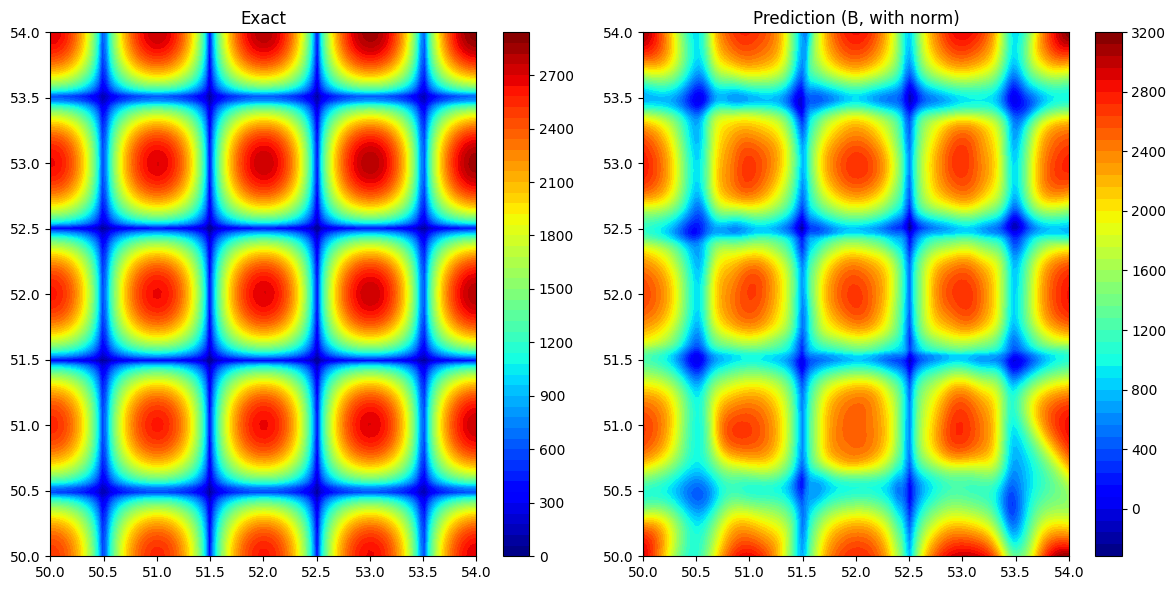

In [44]:
# 테스트 정규화→예측→역정규화
net_B = _new_reg2d_net()
ckpt_B = os.path.join(cfg.network_dir, "u_network.0.pth")
net_B.load_state_dict(torch.load(ckpt_B, map_location="cpu"))
net_B.eval()
with torch.no_grad():
    X1n = (invar_test_2d["x"] - X_mean[:, 0:1]) / X_std[:, 0:1]
    X2n = (invar_test_2d["y"] - X_mean[:, 1:2]) / X_std[:, 1:2]
    X1n_t = torch.from_numpy(X1n).float()
    X2n_t = torch.from_numpy(X2n).float()
    Yp_B_n = net_B({"x": X1n_t, "y": X2n_t})["u"].cpu().numpy().reshape(-1,1)
    Yp_B = (Yp_B_n * y_std + y_mean).reshape(X1g.shape)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.contourf(X1g, X2g, Y_exact, levels=50, cmap="jet"); plt.colorbar(); plt.title("Exact")
plt.subplot(1,2,2); plt.contourf(X1g, X2g, Yp_B,   levels=50, cmap="jet"); plt.colorbar(); plt.title("Prediction (B, with norm)")
plt.tight_layout(); plt.show()

# Poisson problem

다음 Poisson 문제를 모델 학습을 통해 해결합니다.
$$ -u''(x) = f(x), \qquad x\in[-1,1], \qquad u(-1)=u(1)=0 $$
where $ f(x) = 5\pi^2 \sin(\pi x) + 64\pi^2\sin(8\pi x) + 128\pi^2\sin(16\pi x).$
이 문제의 exact solution은
$$u(x) = 5\sin(\pi x) +\sin(8\pi x)+0.5\sin(16\pi x).$$
입니다.

Loss function은 Residual Loss와 Boundary Loss 두 항으로 구성됩니다.

$$
L(\theta) = w_R \underbrace{\frac{1}{N_R} \sum_{i=1}^{N_R} \left| \hat{u}''(x_i)+f(x_i) \right|^2 }_{\text{residual loss}}
+ w_B \underbrace{\frac{1}{N_B} \sum_{i=1}^{N_B} \left| \hat{u}(x^{BC}_i) \right|^2}_{\text{boundary loss}}
$$
        
여기서 $w_R$ , $w_B$ 는 각 손실의 가중치 입니다.

### 이 예제를 통해 FFE와 적절한 $w_B$ 선택의 중요성을 확인합니다.

##### **[참고]** 이번 예제는 PhysicsNeMo의 Solver를 사용하지 않고, 학습 루프를 직접 작성해보며, 학습 과정을 더 자세히 들여다 봅니다.

In [45]:
import sys, time, math

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from physicsnemo.distributed import DistributedManager
from physicsnemo.launch.logging import PythonLogger
from physicsnemo.models.mlp.fully_connected import FullyConnected
from physicsnemo.sym.geometry.primitives_1d import Line1D
from physicsnemo.sym.geometry.geometry_dataloader import GeometryDatapipe

### Define Exact Solution

In [46]:
# -----------------------------
# Exact solution / forcing
# -----------------------------
def exact_solution_np(x: np.ndarray) -> np.ndarray:
    return 5*np.sin(np.pi*x) + np.sin(8*np.pi*x) + 0.5*np.sin(16*np.pi*x)

def forcing_torch(x: torch.Tensor) -> torch.Tensor:
    # f(x) = 5π^2 sin(πx) + 64π^2 sin(8πx) + 128π^2 sin(16πx)
    pi2 = (math.pi**2)
    return pi2 * (5*torch.sin(math.pi*x) + 64*torch.sin(8*math.pi*x) + 128*torch.sin(16*math.pi*x))


### Define PDE : Poisson1D

In [47]:
# -----------------------------
# PDE residual (custom)
# -----------------------------
class Poisson1D:
    """Residual r = u_xx + f(x) (target r=0)."""
    def residual(self, x: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
        # x needs requires_grad=True
        ones = torch.ones_like(u)
        u_x  = torch.autograd.grad(u, x, ones, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
        f = forcing_torch(x)
        return u_xx + f

### Define Model

In [48]:
# -----------------------------
# Fourier Features
# -----------------------------
class FourierFeatures(nn.Module):
    def __init__(self, input_dim: int, mapping_size: int, scale: float):
        super().__init__()
        self.B = nn.Parameter(scale * torch.randn((input_dim, mapping_size)), requires_grad=False)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_proj = 2*math.pi * (x @ self.B)        # [N,1]@[1,M]->[N,M]
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

In [49]:
# -----------------------------
# PN-only model (FullyConnected)
# -----------------------------
class PoissonModel(nn.Module):
    def __init__(self, hidden_dim: int, hidden_layers: int, out_dim: int,
                 use_ff: bool=False, ff_m: int=10, ff_scale: float=3.0):
        super().__init__()
        self.use_ff = use_ff
        if use_ff:
            self.ff = FourierFeatures(1, ff_m, ff_scale)
            in_dim = 2*ff_m
        else:
            self.ff = None
            in_dim = 1
        self.backbone = FullyConnected(
            in_features=in_dim,
            out_features=out_dim,
            num_layers=hidden_layers + 2,    # 입력/출력 포함 총 레이어 수로 간주
            layer_size=hidden_dim
        )
    def forward(self, x):
        if self.use_ff:
            x = self.ff(x)
        return self.backbone(x)

### Training loop

모델을 학습하는 함수입니다.

구성요소
- model : 학습할 모델
- optimizer : 학습에 사용할 최적화 함수 - (참고 : )보통 Adam(Adaptive Moment Estimation) optimizer를 많이 사용합니다.
- data : 학습할 domain의 collocation point, boundary point를 포함합니다.
- epochs : 학습 loop를 몇번 작동시킬지 결정합니다.
- w_B : boundary Loss의 가중치를 결정합니다.

In [50]:
# -----------------------------
# Train / Eval utilities (with timing)
# -----------------------------
def train_one(model, optimizer, line_dp_int, line_dp_bc, epochs=3000, w_B=100.0, log_interval=200, desc="train"):
    crit = nn.MSELoss() # Loss 종류 : Mean Squared Error Loss : (예측-목표)^2
    t0 = time.perf_counter()
    pde = Poisson1D()

    for epoch in range(1, epochs+1):

        # dataset - batch
        # [데이터 샘플링] 매 epoch마다 새 점들을 샘플링합니다.
        int_batch = next(iter(line_dp_int))[0] # 내부 점(Residual)
        bc_batch  = next(iter(line_dp_bc ))[0] # 경계 점(Boundary Condition)

        # 내부 collocation (x_f with grad)
        # [PDE 잔차 loss] r = u_xx + f = 0 를 만족시키도록 학습합니다.
        x_f = int_batch["x"].reshape(-1,1) # (N, 1)로 모양 정리
        x_f = x_f.requires_grad_(True)
        u_f = model(x_f)                   # u(x_f) 예측 (모양: (N, 1))

        # u_x = du/dx, u_xx = d^2u/dx^2.
        r   = pde.residual(x_f, u_f) # r(x_f) = u_xx(x_f) + f(x_f)

        # 목표 r=0
        loss_pde = crit(r, torch.zeros_like(r))

        # [경계조건 loss] x=-1, +1에서 u=0을 강제합니다.
        x_s = bc_batch["x"].reshape(-1,1)
        eps = 1e-6
        mask_L = torch.isclose(x_s.squeeze(-1), torch.tensor(-1.0, device=x_s.device, dtype=x_s.dtype), atol=eps)
        mask_R = torch.isclose(x_s.squeeze(-1), torch.tensor(+1.0, device=x_s.device, dtype=x_s.dtype), atol=eps)

        loss_bc = torch.zeros((), device=x_s.device)

        # x=-1 부근의 예측
        if mask_L.any():
            uL = model(x_s[mask_L])
            loss_bc = loss_bc + (uL**2).mean()

        # x=+1 부근의 예측
        if mask_R.any():
            uR = model(x_s[mask_R])
            loss_bc = loss_bc + (uR**2).mean()

        # [총 손실] PDE 잔차 + w_B * 경계
        loss = loss_pde + w_B*loss_bc

        # [표준 학습 패턴] optimizer 초기화 → 역전파 → 파라미터 갱신
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # [로깅, 확인용] 주기적으로 현재 손실과 시간 정보를 출력
        if epoch % log_interval == 0 or epoch == 1 or epoch == epochs:
            elapsed = time.perf_counter() - t0
            avg_ms  = (elapsed/epoch)*1000.0
            print(f"[{desc}] ep {epoch:5d}/{epochs:5d} | "
                  f"PDE={loss_pde.item():.3e} BC={loss_bc.item():.3e} | "
                  f"Total={loss.item():.3e} | elapsed={elapsed:7.2f}s avg/ep={avg_ms:6.2f} ms")

@torch.no_grad()
def eval_on_grid(model, x_linspace: np.ndarray, device) -> np.ndarray:
    """
    학습된 모델을 일정 간격의 격자 위에서 평가해 곡선을 그릴 때 사용.
    - @torch.no_grad(): 평가 중에는 그래디언트가 필요 없으므로 메모리/속도 절약
    - 입력: x_linspace (numpy 1D)
    - 출력: 예측값 y (numpy 1D)
    """
    x = torch.from_numpy(x_linspace.astype(np.float32)).view(-1,1).to(device)
    y = model(x).cpu().numpy().reshape(-1)
    return y

In [51]:
# Dist/Logger
DistributedManager.initialize()
dist = DistributedManager()
device = dist.device
log = PythonLogger("bvp_poisson")
log.file_logging()

/usr/local/lib/python3.12/dist-packages/physicsnemo/distributed/manager.py:415: UserWarning: Could not initialize using ENV, SLURM or OPENMPI methods. Assuming this is a single process job
  warn(


### Training Runner
- 다양한 학습 세팅 실험을 진행하고 plot까지 자동화
####구성요소
- device : 학습에 사용할 장치cpu or gpu
- line_dp_int, line_dp_bc : collocation, Boundary Datapipe
- x_test : 평가용 x 그리드
- u_exact : exact solution 정보
- 모델 구조 hyperparameter
  - hidden_dim : 은닉측 사이즈
  - hidden_layers : 은닉층 개수
  - output_dim : 출력 차원
- FFE hyperparameter
  - mapping_size : sin, cos mapping할 size
  - scale
- lr : learning rate
    
    Loss = 0 optimizing 과정에서 사용됩니다. 한번의 loop에 진행할 optimizing step size를 결정합니다.
- epochs : 총 학습 loop 횟수를 의미합니다.
- variant : 다양한 실험 setting값을 runner에 전달합니다.

In [52]:
import numpy as np
import matplotlib as mpl

### plot helper
def _make_variant_styles(tags, seed=42):
    rng = np.random.default_rng(seed)
    n = len(tags)
    # 색상: HSV에서 균등 분할 → 서로 다른 색
    hues = np.linspace(0.0, 1.0, n, endpoint=False)
    colors = [mpl.colors.to_hex(mpl.colors.hsv_to_rgb((h, 0.75, 0.85))) for h in hues]
    rng.shuffle(colors)  # 순서만 랜덤

    ls_pool = ['-', '--', '-.', ':']
    return {
        t: dict(c=colors[i], ls=ls_pool[rng.integers(len(ls_pool))], lw=2.0)
        for i, t in enumerate(tags)
    }

In [53]:
def run(
  device, line_dp_int, line_dp_bc, x_test, u_exact,
  hidden_dim, hidden_layers, output_dim, mapping_size, scale,
  lr,  epochs,  log_interval, variants, seed = 42
  ):
    preds = {}
    for vi, v in enumerate(variants, 1):
        torch.manual_seed(seed); np.random.seed(seed)
        print(f"\n=== Variant {vi}/{len(variants)} :: {v['tag']} ===")
        model = PoissonModel(
            hidden_dim=hidden_dim,
            hidden_layers=hidden_layers,
            out_dim=output_dim,
            use_ff=v["use_ff"],
            ff_m=mapping_size,
            ff_scale=scale
        ).to(device)

        opt = optim.Adam(model.parameters(), lr=lr)
        train_one(model, opt, line_dp_int, line_dp_bc,
                  epochs=epochs, w_B=v["wB"], log_interval=log_interval,
                  desc=v["tag"])
        model.eval()
        preds[v["tag"]] = eval_on_grid(model, x_test, device)

    # 3) Plot
    plt.figure(figsize=(10,8))
    plt.plot(x_test, u_exact, 'k-', linewidth=2.0, label='Exact')

    tags = list(preds.keys())
    styles = _make_variant_styles(tags, seed=seed)

    for tag, yhat in preds.items():
        plt.plot(x_test, yhat, label=tag, **styles[tag])

    plt.xlabel('x'); plt.ylabel('u(x)')
    plt.title('Poisson 1D — PINN (PN FullyConnected) with variants')
    plt.legend(); plt.tight_layout(); plt.show()

    log.info("Poisson 1D experiments done.")


### 학습 데이터 생성

In [54]:
# Data
N_R= 100         # collocation points (interior)
N_B= 2           # boundary points (surface sampler target)
x_min= -1.0
x_max=  1.0
N_test= 1000

In [55]:
# 1) Domain & DataPipes
line = Line1D(x_min, x_max)
line_dp_int = GeometryDatapipe(
    geom_objects=[line], batch_size=1, num_points=N_R,
    sample_type="volume", device=device, num_workers=1, requested_vars=["x"]
)
line_dp_bc  = GeometryDatapipe(
    geom_objects=[line], batch_size=1, num_points=N_B,
    sample_type="surface", device=device, num_workers=1, requested_vars=["x"]
)

# Test grid (for plotting/eval)
x_test = np.linspace(x_min, x_max, N_test, dtype=np.float32)
u_exact = exact_solution_np(x_test)

### 학습 Hyperparameter Setting

- 주의사항 : 새로운 세팅으로 실험을 진행할때
  - hyperparameter setting을 변경하세요
  - 반드시 다음의 코드 블록을 모두 순서대로 실행해야 합니다.

In [56]:
# model
hidden_dim= 100
hidden_layers= 3
output_dim= 1

# fourier
mapping_size= 10
scale= 3.0

# train
lr= 1.0e-3
epochs= 3000
log_interval= 200

#loss - boundary loss weight 값 세팅에 따른 비교 실험
bc_w_alt= 1.0
bc_w_default= 100.0

# run
seed = 42

#### FFE 와 Boundray Loss weight Setting을 다양하게 하여 비교 실험 진행
- use_ff 를 통해 FFE 사용 여부를 결정합니다. (True/False)
- wB에 bc_w_alt 혹은 bc_w_default를 전달하여 boundary Loss weight을 설정합니다.
- 총 4가지 경우의 수에 대해 비교합니다.

In [57]:
variants = [
        dict(use_ff=True,  wB=float(bc_w_default), tag="FFE_wB=100"),
        dict(use_ff=True,  wB=float(bc_w_alt),     tag="FFE_wB=1"),
        dict(use_ff=False, wB=float(bc_w_default), tag="noFFE_wB=100"),
        dict(use_ff=False, wB=float(bc_w_alt),     tag="noFFE_wB=1"),
    ]

### Runner 실행
- 실험 결과 ffe를 적용한 모델은 기본 모델에 비해 예측 성능이 뛰어난것을 확인할 수 있다.
- ffe를 적용한 모델 중에서도 boundary loss weight이 100인 경우가 1인 경우에 비해 성능이 좋은것을 확인할 수 있다.
- ffe, boundary loss weight 설정이 학습에 미치는 영향에 대해 이해할 수 있다.


=== Variant 1/4 :: FFE_wB=100 ===
[FFE_wB=100] ep     1/ 3000 | PDE=1.018e+06 BC=6.166e-04 | Total=1.018e+06 | elapsed=  21.42s avg/ep=21416.77 ms
[FFE_wB=100] ep   200/ 3000 | PDE=1.114e+03 BC=9.539e-01 | Total=1.210e+03 | elapsed=  28.40s avg/ep=141.98 ms
[FFE_wB=100] ep   400/ 3000 | PDE=5.048e+02 BC=1.279e+00 | Total=6.326e+02 | elapsed=  32.56s avg/ep= 81.41 ms
[FFE_wB=100] ep   600/ 3000 | PDE=2.832e+02 BC=4.181e-01 | Total=3.250e+02 | elapsed=  37.26s avg/ep= 62.10 ms
[FFE_wB=100] ep   800/ 3000 | PDE=9.770e+01 BC=1.047e-01 | Total=1.082e+02 | elapsed=  42.59s avg/ep= 53.23 ms
[FFE_wB=100] ep  1000/ 3000 | PDE=5.700e+01 BC=2.578e-02 | Total=5.958e+01 | elapsed=  51.12s avg/ep= 51.12 ms
[FFE_wB=100] ep  1200/ 3000 | PDE=1.553e+02 BC=9.717e-03 | Total=1.563e+02 | elapsed=  56.71s avg/ep= 47.26 ms
[FFE_wB=100] ep  1400/ 3000 | PDE=1.015e+02 BC=2.056e-03 | Total=1.017e+02 | elapsed=  62.07s avg/ep= 44.33 ms
[FFE_wB=100] ep  1600/ 3000 | PDE=2.165e+01 BC=6.293e-04 | Total=2.171e+01 

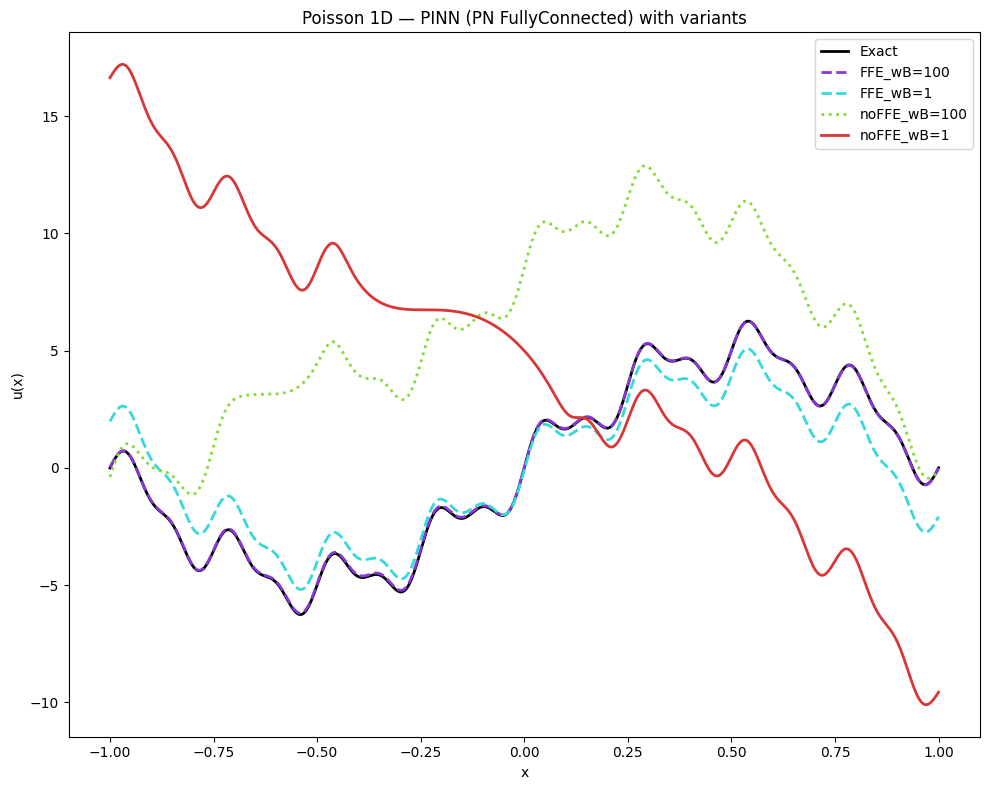

[INFO] bvp_poisson: Poisson 1D experiments done.


In [58]:
# Run
run(device, line_dp_int, line_dp_bc, x_test, u_exact,
  hidden_dim, hidden_layers, output_dim, mapping_size, scale,
  lr,  epochs,  log_interval, variants, seed)

# [PDE] Burgers' equation 예제

- 다음과 같은 Burgers' equation에 대해 PINN 학습을 진행합니다.
$$u_t+u u_x -\nu u_{xx}=0, \quad (x,t)\in\Omega$$
$$ u(x,0) = -\sin(\pi x) $$
$$u(-1,t)=u(1,t)=0$$
where $ \Omega = [-1,1]\times[0,1]$.

  Take $\nu = \frac{0.01}{\pi}$.

## Burgers' equation 정의
- **physicsnemo의 PDE 클래스**를 상속하여 burgers' equation을 정의합니다

In [117]:
from physicsnemo.sym.eq.pde import PDE
from numpy import pi
from sympy import Symbol, Eq, Abs, Number, Function
from omegaconf import OmegaConf, open_dict

In [118]:
class CustomPDE(PDE):
    name = "BurgersEquation1D"
    def __init__(self, alpha = 0.01/pi):
        ## coordinates
        x = Symbol("x")
        ## time
        t = Symbol("t")

        ## Make input variables
        input_variables = {"t":t, "x":x}

        ## Make u function
        u = Function("u")(*input_variables)

        ## Coefficient alpha
        if type(alpha) is str:
            alpha = Function(alpha)(*input_variables)
        elif type(alpha) in [float, int]:
            alpha = Number(alpha)

        ## Set equations
        self.equations = {}
        self.equations["Burgers"] = (
            u.diff(t) + u*u.diff(x) - alpha*u.diff(x,2)
        ) ## "custom_pde" key name will be used in constraints

In [119]:
Burgers = CustomPDE(alpha = 0.01/pi)

### Load Configuration

In [120]:
%cd /content/physicsnemo_tutorial/PINNs/Burgers/conf/
%mkdir /tmp/conf
%cp config_Burgers.yaml /tmp/conf
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()
initialize(version_base="1.3", config_path="conf")
config_name = "config_Burgers"
cfg = compose(config_name=config_name)

/content/physicsnemo_tutorial/PINNs/Burgers/conf
mkdir: cannot create directory ‘/tmp/conf’: File exists


In [121]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(name)s: %(message)s', force=True)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
stream_handler = logging.StreamHandler()
logger.addHandler(stream_handler)

### Loss graph PostProcessing Code - Train Logger에 부착

In [122]:
# ===========================================
# 손실 CSV/NPZ 로거
#    - physicsnemo.sym.trainer 로그 파싱 → CSV/NPZ 저장
# ===========================================
import logging, os, re, csv, numpy as np
class TrainerLossLogger(logging.Handler):
    _pat = re.compile(
        r"\[step:\s*(\d+)\]\s+loss:\s+([0-9eE\+\-\.]+)(?:,\s*time/iteration:\s*([0-9eE\+\-\.]+)\s*ms)?"
    )
    def __init__(self, out_dir, csv_name="loss_log.csv", npz_name="loss_history.npz"):
        super().__init__(level=logging.INFO)
        self.out_dir = out_dir
        os.makedirs(out_dir, exist_ok=True)
        self.csv_path = os.path.join(out_dir, csv_name)
        self.npz_path = os.path.join(out_dir, npz_name)
        self.steps, self.losses, self.times = [], [], []
        self._last_step = None
        with open(self.csv_path, "w", newline="") as f:
            csv.writer(f).writerow(["step", "loss", "time_ms"])

    def emit(self, record):
        m = self._pat.search(record.getMessage())
        if not m:
            return
        step = int(m.group(1))
        loss = float(m.group(2))
        t_ms = float(m.group(3)) if m.group(3) is not None else ""
        if self._last_step == step:
            return
        self._last_step = step
        with open(self.csv_path, "a", newline="") as f:
            csv.writer(f).writerow([step, loss, t_ms])
        self.steps.append(step)
        self.losses.append(loss)
        self.times.append(np.nan if t_ms == "" else float(t_ms))

    def save_npz(self):
        np.savez(self.npz_path,
                 step=np.array(self.steps, dtype=np.int64),
                 loss=np.array(self.losses, dtype=np.float64),
                 time_ms=np.array(self.times, dtype=np.float64))
        return self.npz_path, self.csv_path

## 학습 모델 정의
- physicsnemo에는 다양한 모델 클래스가 존재합니다.

- 이번 학습에서 사용할 fully connected MLP 모델은 다음과 같이 사용할 수 있습니다

In [123]:
from physicsnemo.sym.key import Key
from physicsnemo.sym.hydra import to_absolute_path, instantiate_arch
from physicsnemo.sym.models.activation import Activation
from physicsnemo.sym.models.fully_connected import FullyConnectedArch

In [124]:
def new_burgers_net():
  return FullyConnectedArch(
    input_keys=[Key("t"), Key("x")],
    output_keys=[Key("u")],
    nr_layers=cfg.arch.fully_connected.nr_layers,
    layer_size=cfg.arch.fully_connected.layer_size,
    activation_fn=cfg.arch.fully_connected.activation_fn,
  )

### hyperparameter setting

- 주의사항 : 새로운 세팅으로 실험을 진행할때
  - model name (모델 저장 폴더) 를 변경하세요
  - hyperparameter setting을 변경하세요
  - 반드시 다음의 코드 블록을 모두 순서대로 실행해야 합니다.

In [125]:
model_name = "outputs_Burgers"
with open_dict(cfg):
    cfg.network_dir = model_name
    cfg.training.max_steps = 5000
    cfg.arch.fully_connected.layer_size = 64
    cfg.arch.fully_connected.nr_layers = 4
    cfg.arch.fully_connected.activation_fn = Activation.TANH

##### model 정의

In [126]:
u_net = new_burgers_net()

node 정의
- physicsnemo의 PDE 클래스의 기능인 **make_nodes()** 를 통해
- PDE와 Network를 하나로 묶어줍니다.

In [127]:
nodes = Burgers.make_nodes() + [u_net.make_node(name="u_network")]

## 학습 도메인 설정

- **physicsnemo의 도메인 설정 라이브러리인 geometry**를 활용하여 정의합니다.

- 1D, 2D 등 다양한 domain에 대해 정의할 수 있습니다.

- 1D 상에서의 학습을 위해 Line1D를 활용합니다.

In [128]:
from physicsnemo.sym.geometry.primitives_1d import Line1D

In [129]:
t, x = Symbol("t"), Symbol("x")

geo = Line1D(-1,1)
time_range = {t:(0,1)}

## 학습 제약조건 설정
- **physicsnemo의 제약조건 설정 라이브러리인 constraint**를 활용하여 제약조건을 정의합니다.

In [130]:
from physicsnemo.sym.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseInteriorConstraint,
)
from physicsnemo.sym.solver import Solver
from physicsnemo.sym.domain import Domain
from sympy import sin

### Domain 제약조건 등록

- 빈 domain을 생성합니다.

In [131]:
domain = Domain()

- 제약조건을 설정합니다.
- 앞서 정의한 다음 항목들을 제약조건에 등록합니다.
  - nodes (PDE, Network)
  - domain

In [132]:
## Initial Condition
IC = PointwiseInteriorConstraint(
    nodes = nodes,
    geometry = geo,
    outvar = {"u": -sin(pi*x)},
    batch_size = 300, ## What is the meaning of batch_size and cfg?
    parameterization={t:0.0},
    batch_per_epoch=1,
)

## Boundary Condition
BC = PointwiseBoundaryConstraint(
    nodes = nodes,
    geometry= geo,
    outvar={"u":0},
    batch_size = 700,
    parameterization=time_range,
    batch_per_epoch=1,
)

## Interior
interior = PointwiseInteriorConstraint(
    nodes = nodes,
    geometry = geo,
    outvar = {"Burgers":0},
    batch_size = 6000,
    parameterization=time_range,
    batch_per_epoch=1,
)

[INFO] physicsnemo.sym.graph: Arch Node: u_network has been converted to a FuncArch node.
Arch Node: u_network has been converted to a FuncArch node.


- domain에 제약조건을 등록 합니다.

In [133]:
domain.add_constraint(IC,"IC")
domain.add_constraint(BC,"BC")
domain.add_constraint(interior, "interior")

### Ground Truth

In [134]:
import numpy as np
import scipy.io
%cd /content

data = scipy.io.loadmat('/content/physicsnemo_tutorial/PINNs/Burgers/data/burgers.mat')
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.transpose(np.real(data['usol']))
X, T = np.meshgrid(x,t)
X = X.flatten()[:,None]
T = T.flatten()[:,None]
u_star = Exact.flatten()[:,None]

/content


### 모델 학습 시작

- **physicsnemo solver**를 활용하여 간단하게 학습을 진행할 수 있습니다

- solver에 domain을 전달합니다.
- **domain에는 제약조건, nodes(PDE-Network), domain geo (1D)와 같은 정보가 들어가 있습니다.**
- cfg에는 모델 학습 하이퍼파라미터 설정 값들이 들어가 있습니다.

In [135]:
# --- 강제 로깅 초기화(중복 핸들러 방지, 레벨 보장) ---
import logging
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(name)s: %(message)s', force=True)
for name in ["physicsnemo", "physicsnemo.sym", "physicsnemo.sym.trainer"]:
    logging.getLogger(name).setLevel(logging.INFO)

trainer_logger = logging.getLogger("physicsnemo.sym.trainer")
loss_logger = TrainerLossLogger(out_dir=cfg.network_dir)
trainer_logger.addHandler(loss_logger)

In [136]:
slv = Solver(cfg, domain)
## Start solver
slv.solve()

[WARNING] physicsnemo.sym.trainer: Installed PyTorch version 2.8.0+cu126 is not TorchScript supported in PhysicsNeMo. Version 2.1.0a0+4136153 is officially supported.
[INFO] physicsnemo.sym.trainer: attempting to restore from: /content/outputs_Burgers
[WARNING] physicsnemo.sym.trainer: optimizer checkpoint not found
[WARNING] physicsnemo.sym.trainer: model u_network.0.pth not found
[INFO] physicsnemo.sym.trainer: [step:          0] record constraint batch time:  6.330e-02s
[INFO] physicsnemo.sym.trainer: [step:          0] saved checkpoint to /content/outputs_Burgers
[INFO] physicsnemo.sym.trainer: [step:          0] loss:  1.191e+00
[INFO] physicsnemo.sym.trainer: Attempting cuda graph building, this may take a bit...
[INFO] physicsnemo.sym.trainer: [step:        100] loss:  3.227e-01, time/iteration:  1.361e+02 ms
[INFO] physicsnemo.sym.trainer: [step:        200] loss:  2.836e-01, time/iteration:  1.725e+01 ms
[INFO] physicsnemo.sym.trainer: [step:        300] loss:  2.634e-01, time

In [137]:
# --- 학습 후 정리(파일 저장, 핸들러 해제) ---------------------------------
npz_path, csv_path = loss_logger.save_npz()
trainer_logger.removeHandler(loss_logger)
print(f"[saved] {csv_path}\n[saved] {npz_path}")

[saved] outputs_Burgers/loss_log.csv
[saved] outputs_Burgers/loss_history.npz


### Loss graph

- 학습이 진행되면서 Loss가 0에 가까워 지는것을 볼 수 있습니다.
- 이는 학습이 잘 진행되고 있다는 지표로도 볼 수 있습니다.

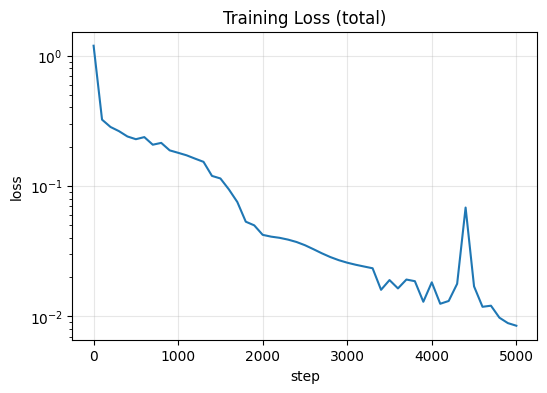

In [138]:
# --- 손실 그래프 그리기 (CSV 기준) ------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(csv_path)  # 위에서 찍힌 경로 사용
plt.figure(figsize=(6,4))
plt.plot(df["step"], df["loss"])
plt.yscale("log")  # ← 요기!
plt.xlabel("step")
plt.ylabel("loss")
plt.title("Training Loss (total)")
plt.grid(True, alpha=0.3)
plt.show()

### 학습 결과

- 추론 모델을 선언합니다.

In [139]:
u_net_star = FullyConnectedArch(
    input_keys=[Key("t"), Key("x")],
    output_keys=[Key("u")],
    nr_layers=4,
    layer_size=64,
    activation_fn=Activation.TANH,
)

- 학습했던 모델을 추론 모델에 덮어씌웁니다.

In [140]:
import torch
u_net_star.load_state_dict(torch.load("outputs_Burgers/u_network.0.pth"))
u_net_star.cuda()

FullyConnectedArch(
  (_impl): FullyConnectedArchCore(
    (layers): ModuleList(
      (0): FCLayer(
        (linear): WeightNormLinear(in_features=2, out_features=64, bias=True)
      )
      (1-3): 3 x FCLayer(
        (linear): WeightNormLinear(in_features=64, out_features=64, bias=True)
      )
    )
    (final_layer): FCLayer(
      (activation_fn): Identity()
      (linear): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [141]:
input_ = {'t': torch.Tensor(T).cuda(),
          'x': torch.Tensor(X).cuda()}
output = u_net_star(input_)

- 다음과 같이 plot을 그려 결과를 확인할 수 있습니다.

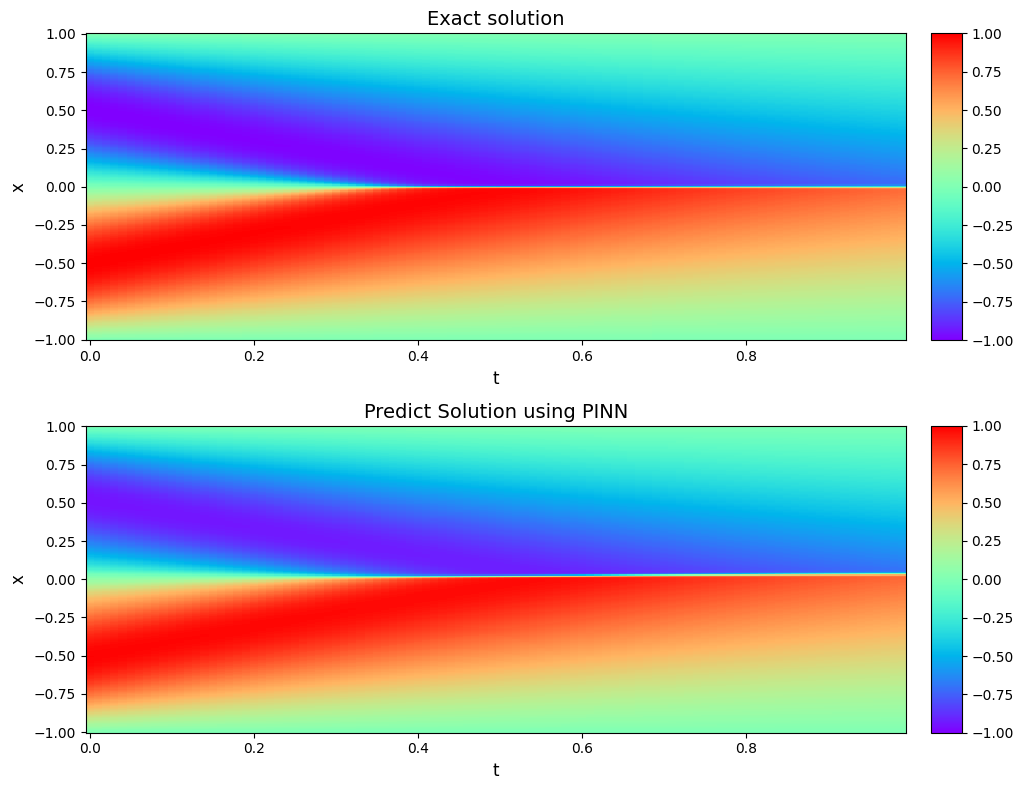

In [142]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
## Plot in 2D
x = X.reshape((100,256))
t = T.reshape((100,256))
u_star = u_star.reshape((100,256))

pred_u = output['u'].cpu().detach().numpy()
pred_u = pred_u.reshape((100,256))
fig = plt.figure(figsize=(11,8))
gs = GridSpec(2, 1)
## Plot Exact Solution
## X_star = (x_i, t_i) i = 1 to 25600 i.e. X_star.shape = (25600,2)
plt.subplot(gs[0,0])
plt.pcolormesh(t, x, u_star,cmap='rainbow')
plt.xlabel('t', fontsize = 12)
plt.ylabel('x', fontsize = 12)
plt.title('Exact solution', fontsize = 14)
cbar = plt.colorbar(pad=0.025, aspect=10)
#cbar.set_label('u(t,x)')
cbar.mappable.set_clim(-1, 1)

## Plot Predict Solution
plt.subplot(gs[1, 0])
plt.pcolormesh(t, x, pred_u, cmap='rainbow')
plt.xlabel('t', fontsize = 12)
plt.ylabel('x', fontsize = 12)
plt.title('Predict Solution using PINN', fontsize = 14)
cbar = plt.colorbar(pad=0.025, aspect=10)
#cbar.set_label('u(t,x)')
cbar.mappable.set_clim(-1, 1)
plt.tight_layout()
plt.show()

- 원하는 시간대의 $u(x,t)$ profile (정답 vs 모델 예측) 을 찍어볼 수 있습니다.
- 원하는 시간값을 t_query에 입력해주세요

In [ ]:
t_query = 0.50  # 원하는 시간 값 (0.00, 0.01, ... , 1.00)

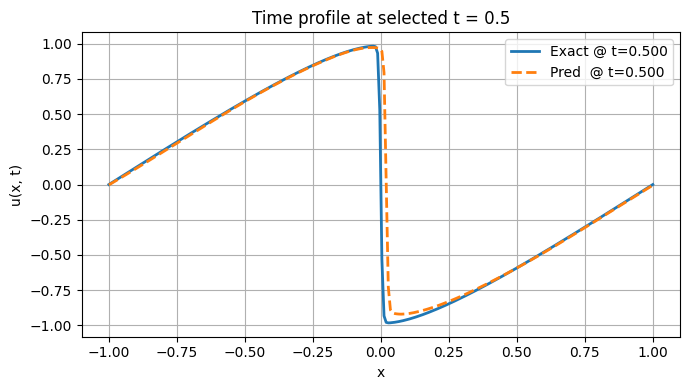

Relative L2 error at t≈0.500: 2.514e-01 (idx=50)


In [143]:
# ----- Time-slice profile (Exact vs Prediction) : axis 자동 판별 -----

# 시간 축 자동 판별
is_time_along_cols = np.allclose(t, np.broadcast_to(t[0:1, :], t.shape))
is_time_along_rows = np.allclose(t, np.broadcast_to(t[:, 0:1], t.shape))

if is_time_along_cols:
    # 시간: 열, 공간: 행
    t_vec = t[0, :]       # (Nt,)
    x_vec = x[:, 0]       # (Nx,)
    j = int(np.argmin(np.abs(t_vec - t_query)))
    t_sel = float(t_vec[j])
    u_exact_slice = u_star[:, j]   # (Nx,)
    u_pred_slice  = pred_u[:, j]   # (Nx,)

elif is_time_along_rows:
    # 시간: 행, 공간: 열  (데이터 reshape 방식에 따라 이 경우일 수 있음)
    t_vec = t[:, 0]       # (Nt,)
    x_vec = x[0, :]       # (Nx,)
    j = int(np.argmin(np.abs(t_vec - t_query)))
    t_sel = float(t_vec[j])
    u_exact_slice = u_star[j, :]   # (Nx,)
    u_pred_slice  = pred_u[j, :]   # (Nx,)

else:
    raise ValueError("시간 축을 한 축으로 판별할 수 없습니다. reshape 순서를 확인하세요.")

if x_vec[0] > x_vec[-1]:
    x_vec = x_vec[::-1]
    u_exact_slice = u_exact_slice[::-1]
    u_pred_slice  = u_pred_slice[::-1]

# 겹쳐 그리기
plt.figure(figsize=(7,4))
plt.plot(x_vec, u_exact_slice, label=f'Exact @ t={t_sel:.3f}', linewidth=2)
plt.plot(x_vec, u_pred_slice,  '--', label=f'Pred  @ t={t_sel:.3f}', linewidth=2)
plt.xlabel('x'); plt.ylabel('u(x, t)')
plt.title(f'Time profile at selected t = {t_query}')
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# 상대 L2 오차
rel_l2 = np.linalg.norm(u_pred_slice - u_exact_slice) / (np.linalg.norm(u_exact_slice) + 1e-12)
print(f"Relative L2 error at t≈{t_sel:.3f}: {rel_l2:.3e} (idx={j})")

# 1D Wave Equation

## [PDE] Wave equation 예제

- 다음과 같은 1차원 파동 방정식(Wave equation)에 대해 PINN 학습을 진행합니다.

$$
u_{tt} = c^2 u_{xx}, \quad (x,t)\in\Omega
$$

$$
u(0,t) = 0, \quad u(\pi,t) = 0
$$

$$
u(x,0) = \sin(x)
$$

$$
u_t(x,0) = \sin(x)
$$

where $\Omega = [0,\pi]\times[0,T]$.

wave speed : $c = 1$.  
The analytical solution to the above problem is given by

$$
u(x,t) = \sin(x)\,(\sin(t) + \cos(t)).
$$

## 1D Wave Equation 정의
- physicsnemo의 PDE 클래스를 상속하여 정의합니다

In [152]:
from sympy import Symbol, Function, Number, sin, pi
from physicsnemo.sym.eq.pde import PDE
from physicsnemo.sym.models.activation import Activation

In [153]:
class WaveEquation1D(PDE):
    name = "WaveEquation1D"
    def __init__(self, c=1.0):
        # 좌표/시간 심볼
        x = Symbol("x")
        t = Symbol("t")

        # 입력 변수 dict
        input_variables = {"x": x, "t": t}

        # u(x,t) 상징함수
        u = Function("u")(*input_variables)

        # 파동 속도 c 처리
        if isinstance(c, str):
            c = Function(c)(*input_variables)
        elif isinstance(c, (float, int)):
            c = Number(c)

        # PDE 잔차 정의: wave_equation = u_tt - (c^2 * u_xx) = 0
        self.equations = {
            "wave_equation": u.diff(t, 2) - (c**2 * u.diff(x, 2))
        }

In [154]:
we = WaveEquation1D(c=1.0)

### Load Configuration

In [155]:
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf, open_dict

In [156]:
%cd /content/physicsnemo_tutorial/PINNs/1D_WaveEquation/conf/
%mkdir /tmp/conf
%cp config_1D_WaveEquation.yaml /tmp/conf
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()
initialize(version_base="1.3", config_path="conf")
config_name = "config_1D_WaveEquation"
cfg = compose(config_name=config_name)

/content/physicsnemo_tutorial/PINNs/1D_WaveEquation/conf
mkdir: cannot create directory ‘/tmp/conf’: File exists


### hyperparameter setting
- 주의사항 : 새로운 세팅으로 실험을 진행할때
  - model name (모델 저장 폴더) 를 변경하세요
  - hyperparameter setting을 변경하세요
  - 반드시 다음의 코드 블록을 모두 순서대로 실행해야 합니다.

In [158]:
model_name = "outputs_1D_WaveEquation"
with open_dict(cfg):
    cfg.network_dir = model_name
    cfg.training.max_steps = 1000
    cfg.arch.fully_connected.layer_size = 512
    cfg.arch.fully_connected.nr_layers = 6
    cfg.arch.fully_connected.activation_fn = "silu" # "tanh", "relu"

## 학습 모델 정의
- physicsnemo의 fully connected MLP를 사용합니다.

In [159]:
# PhysicsNeMo-Sym
from physicsnemo.sym.key import Key
from physicsnemo.sym.hydra import instantiate_arch
from physicsnemo.sym.solver import Solver
from physicsnemo.sym.domain import Domain
from physicsnemo.sym.geometry.primitives_1d import Line1D
from physicsnemo.sym.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseInteriorConstraint,
)
%cd /content

/content


In [160]:
# 네트워크(MLP) 생성
wave_net = instantiate_arch(
    input_keys=[Key("x"), Key("t")],
    output_keys=[Key("u")],
    cfg=cfg.arch.fully_connected,
)

- node를 통해 PDE와 Network를 하나로 묶어줍니다.

In [161]:
# PDE 노드 + 네트워크 노드 결합 (학습 그래프 구성)
nodes = we.make_nodes() + [wave_net.make_node(name="u_network")]

## 학습 도메인 및 제약조건 설정
- physicsnemo geometry, domain, constraint를 통해 정의합니다.

In [162]:
# =========================
# Domain 설정
#     공간: x ∈ [0, π], 시간: t ∈ [0, 2π]
# =========================
x_sym, t_sym = Symbol("x"), Symbol("t")
L = float(np.pi)      # 공간 길이 π
geo = Line1D(0.0, L)  # x ∈ [0, π]
time_range = {t_sym: (0.0, 2.0 * L)}  # t ∈ [0, 2π]

In [163]:
# =========================
# Constraints 구성
#     - IC: u(x,0) = sin(x), u_t(x,0) = sin(x)
#     - BC: u(0,t)=0, u(π,t)=0
#     - Interior: wave_equation = 0
# =========================
domain = Domain()

# Initial Condition (t = 0에서 u, u_t 지정)
IC = PointwiseInteriorConstraint(
    nodes=nodes,
    geometry=geo,
    outvar={"u": sin(x_sym), "u__t": sin(x_sym)},  # u_t 초기조건은 'u__t' 키
    batch_size=cfg.batch_size.IC,
    lambda_weighting={"u": 1.0, "u__t": 1.0},      # 필요 시 cfg로 조정 가능
    parameterization={t_sym: 0.0},
    batch_per_epoch=1,
)

# Boundary Condition (x 경계에서 Dirichlet 0)
BC = PointwiseBoundaryConstraint(
    nodes=nodes,
    geometry=geo,
    outvar={"u": 0},
    batch_size=cfg.batch_size.BC,
    parameterization=time_range,   # t를 [0, 2π]에서 샘플
    batch_per_epoch=1,
)

# PDE Interior (공간-시간 내부에서 파동방정식 잔차=0)
interior = PointwiseInteriorConstraint(
    nodes=nodes,
    geometry=geo,
    outvar={"wave_equation": 0},
    batch_size=cfg.batch_size.interior,
    parameterization=time_range,
    batch_per_epoch=1,
)

[INFO] physicsnemo.sym.graph: Arch Node: u_network has been converted to a FuncArch node.
[INFO] physicsnemo.sym.graph: Arch Node: u_network has been converted to a FuncArch node.


- domain에 제약조건 등록

In [164]:
domain.add_constraint(IC, "IC")
domain.add_constraint(BC, "BC")
domain.add_constraint(interior, "interior")

### Loss graph PostProcessing Code - Train Logger에 부착

In [165]:
# --- 손실 CSV/NPZ 로거 정의 ---------------------------------------------
import logging, os, re, csv, numpy as np

class TrainerLossLogger(logging.Handler):
    """
    physicsnemo.sym.trainer 로그에서 '[step: ####] loss: ###, time/iteration: ### ms'
    패턴을 추출해 CSV와 NPZ로 저장한다.
    """
    _pat = re.compile(
        r"\[step:\s*(\d+)\]\s+loss:\s+([0-9eE\+\-\.]+)(?:,\s*time/iteration:\s*([0-9eE\+\-\.]+)\s*ms)?"
    )
    def __init__(self, out_dir, csv_name="loss_log.csv", npz_name="loss_history.npz"):
        super().__init__(level=logging.INFO)
        self.out_dir = out_dir
        os.makedirs(out_dir, exist_ok=True)
        self.csv_path = os.path.join(out_dir, csv_name)
        self.npz_path = os.path.join(out_dir, npz_name)
        # 메모리 누적 버퍼 (학습 후 NPZ 저장용)
        self.steps, self.losses, self.times = [], [], []
        self._last_step = None
        # CSV 헤더 준비
        with open(self.csv_path, "w", newline="") as f:
            csv.writer(f).writerow(["step", "loss", "time_ms"])

    def emit(self, record):
        msg = record.getMessage()
        m = self._pat.search(msg)
        if not m:
            return
        step = int(m.group(1))
        loss = float(m.group(2))
        t_ms = float(m.group(3)) if m.group(3) is not None else ""
        # 동일 step 중복 방지
        if self._last_step == step:
            return
        self._last_step = step
        # 파일에 한 줄 추가
        with open(self.csv_path, "a", newline="") as f:
            csv.writer(f).writerow([step, loss, t_ms])
        # 메모리에도 적재
        self.steps.append(step)
        self.losses.append(loss)
        self.times.append(np.nan if t_ms == "" else float(t_ms))

    def save_npz(self):
        np.savez(self.npz_path,
                 step=np.array(self.steps, dtype=np.int64),
                 loss=np.array(self.losses, dtype=np.float64),
                 time_ms=np.array(self.times, dtype=np.float64))
        return self.npz_path, self.csv_path

# --- 2) 학습 전에 로거 부착 ---------------------------------------------------
trainer_logger = logging.getLogger("physicsnemo.sym.trainer")
loss_logger = TrainerLossLogger(out_dir=cfg.network_dir)
trainer_logger.addHandler(loss_logger)

### 학습 시작 (1000 epoch 학습에 약 3분 소요)

In [166]:
# =========================
# Solver 생성 & 학습
# =========================
slv = Solver(cfg, domain)
slv.solve()   # 체크포인트는 cfg.network_dir 하위에 저장 (예: u_network.0.pth)

[WARNING] physicsnemo.sym.trainer: Installed PyTorch version 2.8.0+cu126 is not TorchScript supported in PhysicsNeMo. Version 2.1.0a0+4136153 is officially supported.
/usr/local/lib/python3.12/dist-packages/physicsnemo/sym/amp.py:219: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  super().__init__(*args, **kwargs)
[INFO] physicsnemo.sym.trainer: attempting to restore from: /content/outputs_1D_WaveEquation
[WARNING] physicsnemo.sym.trainer: optimizer checkpoint not found
[WARNING] physicsnemo.sym.trainer: model u_network.0.pth not found
[INFO] physicsnemo.sym.trainer: [step:          0] record constraint batch time:  7.895e-02s
[INFO] physicsnemo.sym.trainer: [step:          0] saved checkpoint to /content/outputs_1D_WaveEquation
[INFO] physicsnemo.sym.trainer: [step:          0] loss:  3.198e+00
[INFO] physicsnemo.sym.trainer: Attempting cuda graph building, this may take a bit...
[INFO] physicsnemo.sym.t

In [167]:
# --- 학습 후 정리(파일 저장, 핸들러 해제) ---------------------------------
npz_path, csv_path = loss_logger.save_npz()
trainer_logger.removeHandler(loss_logger)
print(f"[saved] {csv_path}\n[saved] {npz_path}")

[saved] outputs_1D_WaveEquation/loss_log.csv
[saved] outputs_1D_WaveEquation/loss_history.npz


### Loss graph

- 학습이 진행되면서 Loss가 0에 가까워 지는것을 볼 수 있습니다.
- 이는 학습이 잘 진행되고 있다는 지표로도 볼 수 있습니다.

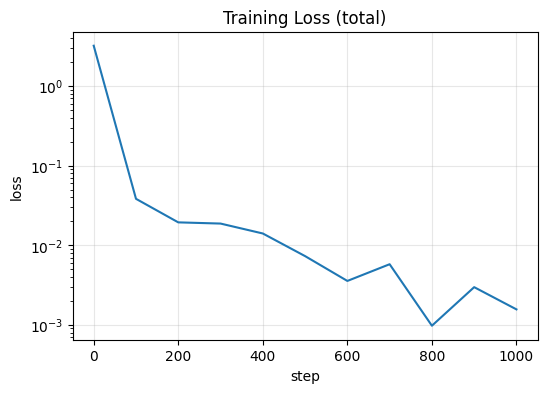

In [168]:
# --- 손실 그래프 그리기 (CSV 기준) ------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(csv_path)  # 위에서 찍힌 경로 사용
plt.figure(figsize=(6,4))
plt.plot(df["step"], df["loss"])
plt.yscale("log")  # ← 요기!
plt.xlabel("step")
plt.ylabel("loss")
plt.title("Training Loss (total)")
plt.grid(True, alpha=0.3)
plt.show()

### 학습 결과 (Ground Truth vs 모델 예측)

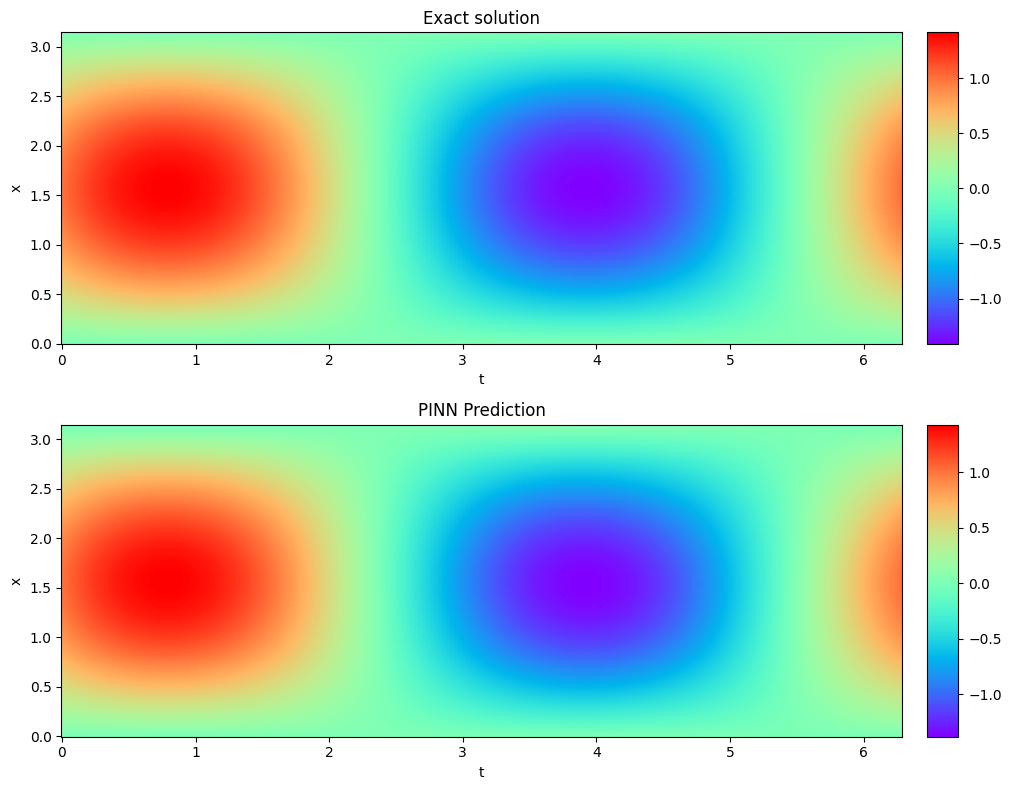

In [169]:
# =========================
# 결과 Plot
#     - GT: u(x,t) = sin(x) * (sin(t) + cos(t))
#     - Pred: 체크포인트 로드 후 그리드 예측
# =========================
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# (9-1) 평가 격자 및 정답 생성
deltaX = 0.01
deltaT = 0.01
xv = np.arange(0.0, L, deltaX)
tv = np.arange(0.0, 2.0 * L, deltaT)
T, X = np.meshgrid(tv, xv, indexing="ij")   # (Nt, Nx)

u_true = np.sin(X) * (np.sin(T) + np.cos(T))  # Analytical solution

# (9-2) 동일 아키텍처로 추론 네트워크 만들고 가중치 로드
u_net_star = instantiate_arch(
    input_keys=[Key("x"), Key("t")],
    output_keys=[Key("u")],
    cfg=cfg.arch.fully_connected,
)

ckpt_path = os.path.join(cfg.network_dir, "u_network.0.pth")
state = torch.load(ckpt_path, map_location="cpu")
u_net_star.load_state_dict(state)
u_net_star.eval()

# (9-3) 예측 수행
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
u_net_star.to(device)

with torch.no_grad():
    inp = {
        "x": torch.tensor(X.reshape(-1, 1), dtype=torch.float32, device=device),
        "t": torch.tensor(T.reshape(-1, 1), dtype=torch.float32, device=device),
    }
    out = u_net_star(inp)
    u_pred = out["u"].detach().cpu().numpy().reshape(T.shape)  # (Nt, Nx)

# (9-4) Plot (정답 vs 예측)
fig = plt.figure(figsize=(11, 8))
gs = GridSpec(2, 1)

# Exact
ax1 = plt.subplot(gs[0, 0])
pc1 = ax1.pcolormesh(T, X, u_true, shading="auto", cmap="rainbow")
ax1.set_xlabel("t"); ax1.set_ylabel("x"); ax1.set_title("Exact solution")
cbar1 = plt.colorbar(pc1, ax=ax1, pad=0.025, aspect=10)

# Predict
ax2 = plt.subplot(gs[1, 0])
pc2 = ax2.pcolormesh(T, X, u_pred, shading="auto", cmap="rainbow")
ax2.set_xlabel("t"); ax2.set_ylabel("x"); ax2.set_title("PINN Prediction")
cbar2 = plt.colorbar(pc2, ax=ax2, pad=0.025, aspect=10)

plt.tight_layout()
plt.show()

# 2D Lid Driven Cavity

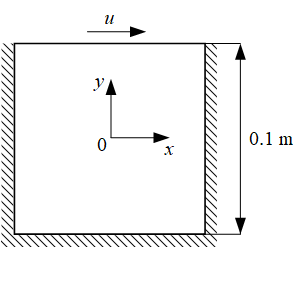

In [170]:
import re
import csv
import numpy as np
import torch
import matplotlib.pyplot as plt
from sympy import Symbol, Eq, Abs, Symbol as SymSymbol

## Lid Driven Cavity problem : Navier-Stokes 정의

In [171]:
from physicsnemo.sym.eq.pdes.navier_stokes import NavierStokes

In [172]:
# ===========================================
# PDE (Navier–Stokes, steady)
# ===========================================
ns = NavierStokes(nu=0.01, rho=1.0, dim=2, time=False)

### Load Configuration

In [173]:
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf, open_dict

In [174]:
%cd /content/physicsnemo_tutorial/PINNs/2D_LDC/conf/
%mkdir /tmp/conf
%cp config_2D_ldc.yaml /tmp/conf
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()
initialize(version_base="1.3", config_path="conf")
config_name = "config_2D_ldc"
cfg = compose(config_name=config_name)

/content/physicsnemo_tutorial/PINNs/2D_LDC/conf
mkdir: cannot create directory ‘/tmp/conf’: File exists


### hyperparameter setting
- 주의사항 : 새로운 세팅으로 실험을 진행할때
  - model name (모델 저장 폴더) 를 변경하세요
  - hyperparameter setting을 변경하세요
  - 반드시 다음의 코드 블록을 모두 순서대로 실행해야 합니다.

In [175]:
model_name = "outputs_2D_LDC"
with open_dict(cfg):
    cfg.network_dir = model_name
    cfg.training.max_steps = 1000
    cfg.arch.fully_connected.layer_size = 512
    cfg.arch.fully_connected.nr_layers = 6
    cfg.arch.fully_connected.activation_fn = "silu" # "tanh", "relu"

%cd /content

/content


## 학습 모델 정의
- physicsnemo의 fully connected MLP모델로 정의합니다.

In [176]:
from physicsnemo.sym.hydra import instantiate_arch

In [177]:
flow_net = instantiate_arch(
    input_keys=[Key("x"), Key("y")],
    output_keys=[Key("u"), Key("v"), Key("p")],
    cfg=cfg.arch.fully_connected,
)

- node를 통해 PDE와 Network를 하나로 묶어줍니다.

In [178]:
nodes = ns.make_nodes() + [flow_net.make_node(name="flow_network")]

## 학습 도메인 및 제약 조건 설정
- physicsnemo geometry, domain, constraint를 통해 정의합니다.

In [179]:
from physicsnemo.sym.domain import Domain
from physicsnemo.sym.key import Key
from physicsnemo.sym.geometry.primitives_2d import Rectangle
from physicsnemo.sym.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseInteriorConstraint,
)

In [180]:
# ===========================================
# Domain / Geometry
# ===========================================
width = 0.1
height = 0.1
x, y = Symbol("x"), Symbol("y")
rec = Rectangle((-width / 2, -height / 2), (width / 2, height / 2))

# 도메인 컨테이너
ldc_domain = Domain()

In [181]:
# ===========================================
# Constraints (Top lid / No-slip / Interior)
#    - Top wall: (u=U, v=0) with edge-weakening
#    - No-slip(그 외 벽): (u=0, v=0)
#    - Interior: continuity=0, momentum_x=0, momentum_y=0
# ===========================================
lid_u = 1.0  # 상단 뚜껑 속도

# Top wall (y = +h/2)
top_wall = PointwiseBoundaryConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={"u": lid_u, "v": 0.0},
    batch_size=cfg.batch_size.TopWall,
    lambda_weighting={"u": 1.0 - 20.0 * Abs(x), "v": 1.0},
    criteria=Eq(y, height / 2),
    batch_per_epoch=1,
)
ldc_domain.add_constraint(top_wall, "top_wall")

# No-slip (상단 제외한 나머지 경계)
no_slip = PointwiseBoundaryConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={"u": 0.0, "v": 0.0},
    batch_size=cfg.batch_size.NoSlip,
    criteria=y < height / 2,   # 경계 샘플 중 상단(y=+h/2) 제외
    batch_per_epoch=1,
)
ldc_domain.add_constraint(no_slip, "no_slip")

# Interior (잔차 = 0), SDF 가중치 사용
interior = PointwiseInteriorConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={"continuity": 0.0, "momentum_x": 0.0, "momentum_y": 0.0},
    batch_size=cfg.batch_size.Interior,
    lambda_weighting={
        "continuity": SymSymbol("sdf"),
        "momentum_x": SymSymbol("sdf"),
        "momentum_y": SymSymbol("sdf"),
    },
    batch_per_epoch=1,
)
ldc_domain.add_constraint(interior, "interior")

[INFO] physicsnemo.sym.graph: Arch Node: flow_network has been converted to a FuncArch node.


### Loss graph PostProcessing Code - Train Logger에 부착

In [182]:
from physicsnemo.sym.solver import Solver

In [183]:
# ===========================================
# 손실 CSV/NPZ 로거
#    - physicsnemo.sym.trainer 로그 파싱 → CSV/NPZ 저장
# ===========================================
import logging, os, re, csv, numpy as np

class TrainerLossLogger(logging.Handler):
    _pat = re.compile(
        r"\[step:\s*(\d+)\]\s+loss:\s+([0-9eE\+\-\.]+)(?:,\s*time/iteration:\s*([0-9eE\+\-\.]+)\s*ms)?"
    )
    def __init__(self, out_dir, csv_name="loss_log.csv", npz_name="loss_history.npz"):
        super().__init__(level=logging.INFO)
        self.out_dir = out_dir
        os.makedirs(out_dir, exist_ok=True)
        self.csv_path = os.path.join(out_dir, csv_name)
        self.npz_path = os.path.join(out_dir, npz_name)
        self.steps, self.losses, self.times = [], [], []
        self._last_step = None
        with open(self.csv_path, "w", newline="") as f:
            csv.writer(f).writerow(["step", "loss", "time_ms"])

    def emit(self, record):
        m = self._pat.search(record.getMessage())
        if not m:
            return
        step = int(m.group(1))
        loss = float(m.group(2))
        t_ms = float(m.group(3)) if m.group(3) is not None else ""
        if self._last_step == step:
            return
        self._last_step = step
        with open(self.csv_path, "a", newline="") as f:
            csv.writer(f).writerow([step, loss, t_ms])
        self.steps.append(step)
        self.losses.append(loss)
        self.times.append(np.nan if t_ms == "" else float(t_ms))

    def save_npz(self):
        np.savez(self.npz_path,
                 step=np.array(self.steps, dtype=np.int64),
                 loss=np.array(self.losses, dtype=np.float64),
                 time_ms=np.array(self.times, dtype=np.float64))
        return self.npz_path, self.csv_path

trainer_logger = logging.getLogger("physicsnemo.sym.trainer")
loss_logger = TrainerLossLogger(out_dir=cfg.network_dir)
trainer_logger.addHandler(loss_logger)

### 학습 시작 (1000 epoch 학습에 약 3분 소요)

In [184]:
# ===========================================
# Solver 실행
# ===========================================
slv = Solver(cfg, ldc_domain)
slv.solve()

[WARNING] physicsnemo.sym.trainer: Installed PyTorch version 2.8.0+cu126 is not TorchScript supported in PhysicsNeMo. Version 2.1.0a0+4136153 is officially supported.
/usr/local/lib/python3.12/dist-packages/physicsnemo/sym/amp.py:219: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  super().__init__(*args, **kwargs)
[INFO] physicsnemo.sym.trainer: attempting to restore from: /content/outputs_2D_LDC
[WARNING] physicsnemo.sym.trainer: optimizer checkpoint not found
[WARNING] physicsnemo.sym.trainer: model flow_network.0.pth not found
/usr/local/lib/python3.12/dist-packages/physicsnemo/sym/eq/derivatives.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
[INFO] physicsnemo.sym.trainer: [step:          0] record constraint batch time:  1.157e-01s
[INFO] physicsnemo.sym.trainer: [step:  

In [185]:
npz_path, csv_path = loss_logger.save_npz()
trainer_logger.removeHandler(loss_logger)
print(f"[saved] {csv_path}\n[saved] {npz_path}")

[saved] outputs_2D_LDC/loss_log.csv
[saved] outputs_2D_LDC/loss_history.npz


### Loss graph

- 학습이 진행되면서 Loss가 0에 가까워 지는것을 볼 수 있습니다.
- 이는 학습이 잘 진행되고 있다는 지표로도 볼 수 있습니다.

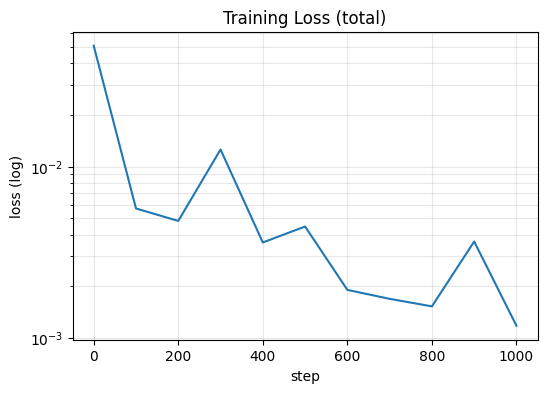

In [186]:
# ===========================================
# Loss 그래프 (로그 스케일)
# ===========================================
import pandas as pd
df = pd.read_csv(csv_path)
eps = 1e-12
plt.figure(figsize=(6,4))
plt.plot(df["step"], df["loss"].clip(lower=eps))
plt.yscale("log")
plt.xlabel("step"); plt.ylabel("loss (log)")
plt.title("Training Loss (total)")
plt.grid(True, which="both", alpha=0.3)
plt.show()

### 학습 결과 (Ground Truth vs 모델 예측)

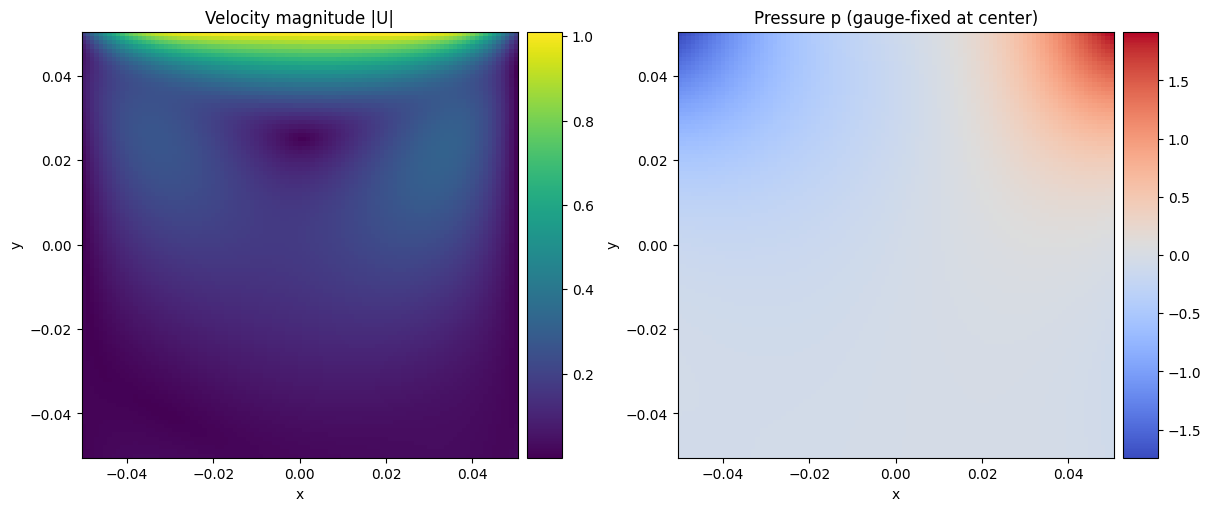

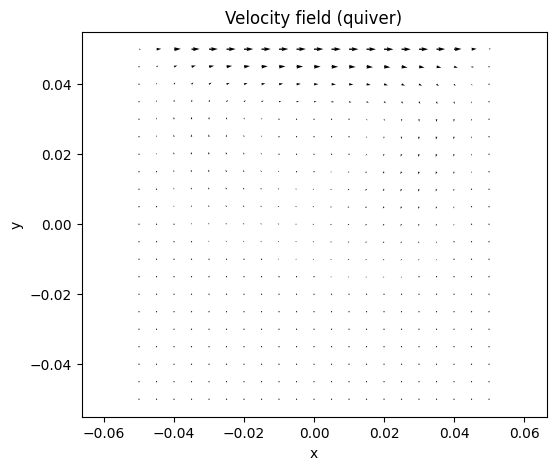

In [187]:
# ===========================================
# 결과 플롯: 속도 크기 |U|, 압력 p, 벡터장(간략 quiver)
# ===========================================
# 동일 아키텍처로 추론 네트워크 구성 + 가중치 로드
flow_net_star = instantiate_arch(
    input_keys=[Key("x"), Key("y")],
    output_keys=[Key("u"), Key("v"), Key("p")],
    cfg=cfg.arch.fully_connected,
)
ckpt_path = os.path.join(cfg.network_dir, "flow_network.0.pth")
state = torch.load(ckpt_path, map_location="cpu")
flow_net_star.load_state_dict(state)
flow_net_star.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
flow_net_star.to(device)

# 균일 격자 샘플
NX = NY = 101
xs = np.linspace(-width/2, width/2, NX)
ys = np.linspace(-height/2, height/2, NY)
YY, XX = np.meshgrid(ys, xs, indexing="ij")  # (NY, NX)
with torch.no_grad():
    inp = {
        "x": torch.tensor(XX.reshape(-1,1), dtype=torch.float32, device=device),
        "y": torch.tensor(YY.reshape(-1,1), dtype=torch.float32, device=device),
    }
    out = flow_net_star(inp)
    U = out["u"].detach().cpu().numpy().reshape(NY, NX)
    V = out["v"].detach().cpu().numpy().reshape(NY, NX)
    P = out["p"].detach().cpu().numpy().reshape(NY, NX)
speed = np.sqrt(U**2 + V**2)

# 플롯: |U|와 p
fig, axes = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True)

pc0 = axes[0].pcolormesh(XX, YY, speed, shading="auto", cmap="viridis")
axes[0].set_title("Velocity magnitude |U|")
axes[0].set_xlabel("x"); axes[0].set_ylabel("y")
plt.colorbar(pc0, ax=axes[0], pad=0.02, aspect=12)

pc1 = axes[1].pcolormesh(XX, YY, P, shading="auto", cmap="coolwarm")
axes[1].set_title("Pressure p (gauge-fixed at center)")
axes[1].set_xlabel("x"); axes[1].set_ylabel("y")
plt.colorbar(pc1, ax=axes[1], pad=0.02, aspect=12)

plt.show()

# 벡터장(간단 quiver, 간격 축소)
step = 5
plt.figure(figsize=(6,5))
plt.quiver(XX[::step, ::step], YY[::step, ::step],
           U[::step, ::step], V[::step, ::step], scale=50)
plt.title("Velocity field (quiver)")
plt.xlabel("x"); plt.ylabel("y")
plt.axis("equal")
plt.show()